## The program below extracts the features from the 4 datasets: Balabit, Chaoshen, DFL and TWOS and teaches the models extracted behaviour. 
The datasets consist of mouse actions


In [1]:
%pip install -r requirments.txt

Note: you may need to restart the kernel to use updated packages.


In [21]:
## IMPORTING THE CLASSES ## 
from utils.consts import * ## const variables are there, so paths and extraction features ##
from utils. plotting import * ## plotting ##
from data_reader_babalit import * ## the class which reads balabit dataset ##
from data_reader_chaoshen import * ## the class which reads chaoshen datasets TODO There are several issues with this dataset -> explained later ##
from data_reader_singapur import * ## the class which reads singapur dataset##
from data_reader_dfl import * ## the class which reads dfl dataset ## 

from nonlegality_analyser import * ## the class which analyses the datasets without 0 1 labels --> splitting samples is being done there ##  
from legality_analyser import * ## the class which analyses the datasets with 0 1 labels --> splitting samples is being done there ##  


from SVMmodel import *
from RandomForestModel import *
from OneClassSVMModel import *
from IsolationForestModel import *

import random

# BALABIT DATASET FEATURE EXTRACTION

In [22]:
## Specyfing the USERS ## 
users = [7,9, 12, 15,16,20,21,23,29, 35] ## those are all users 
## Creating the object which analyses the dataset ## 
limit  = 1000
balabit_reader = DataReaderBalabit(BALABIT, users, False, limit = limit) ## the arguments are DATASET, users, supervised, how many records should be procesed ##
balabit_reader.processDataWithoutLabels() ## creating the data without labels ##



File already exist


In [23]:
## getting path from the reader ##
print(balabit_reader.fileName) 
path = balabit_reader.getFileName()

## creating analyser class ## 
balabitAnalyser = nonLegalityAnalyser(path)
## counting how many actions were extracted ## 
print(balabitAnalyser.countActions())

processed_files\balabit_dataset_users[7, 9, 12, 15, 16, 20, 21, 23, 29, 35]_limit1000_labelsFalse.csv
type_of_action     1    3    4
userid                        
7                679  812   88
9                798  830  107
12              1322  616  116
15               547  641   89
16               538  608  113
20              1141  823   95
21               704  550   90
23               494  703   61
29               357  662  112
35               672  617   94


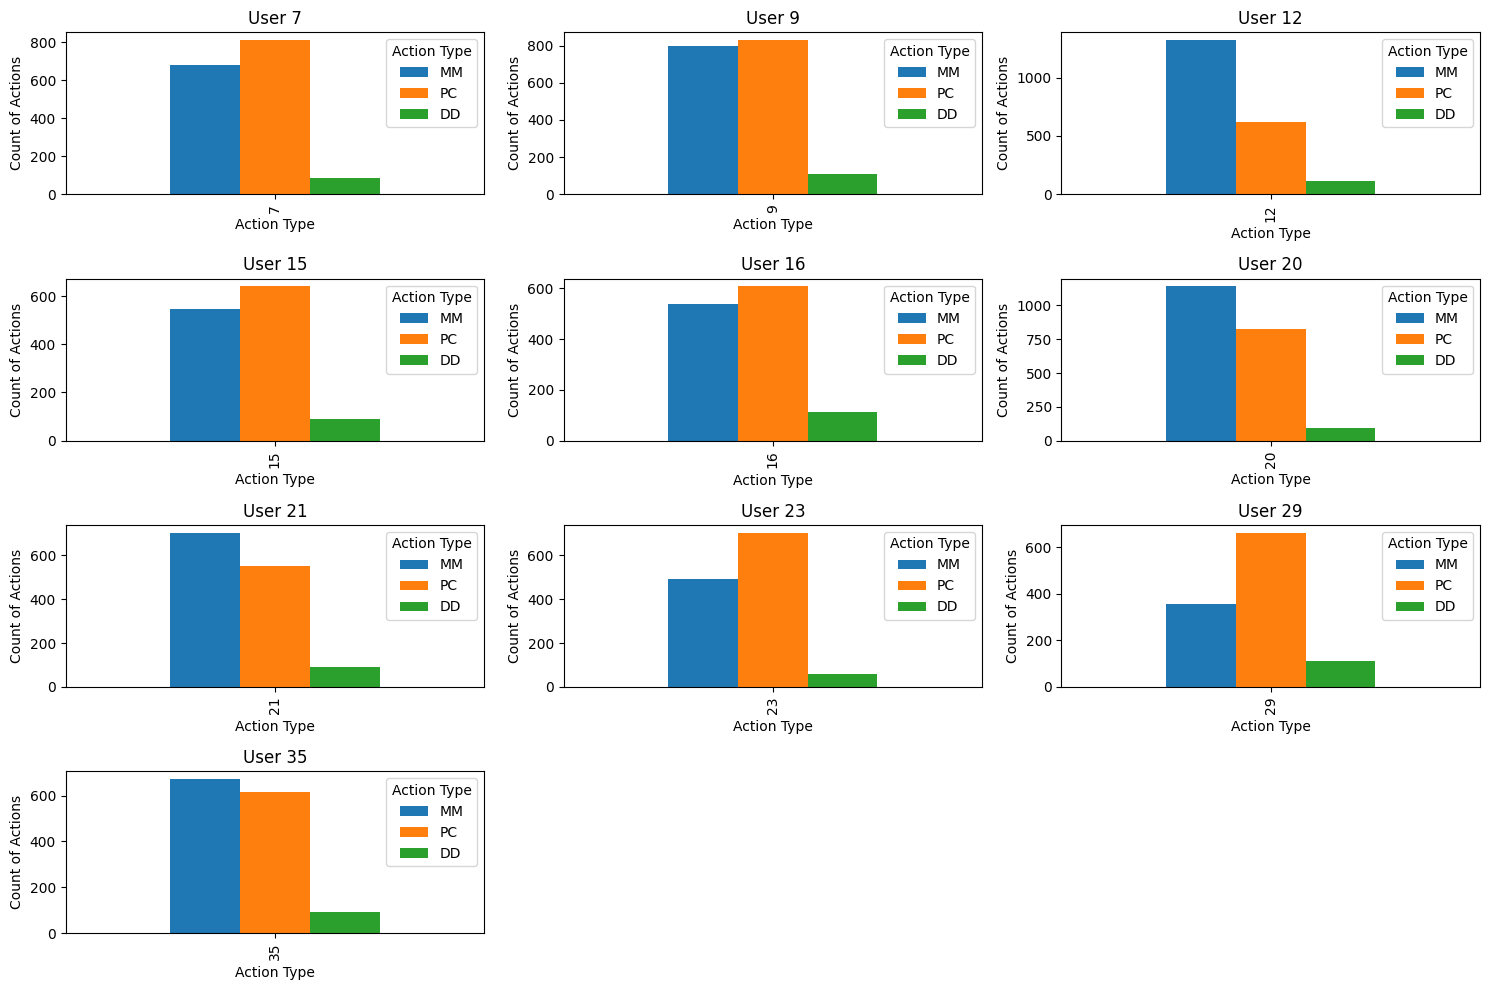

In [5]:
## histogram of actions ## 
balabitAnalyser.plotActionHistograms()

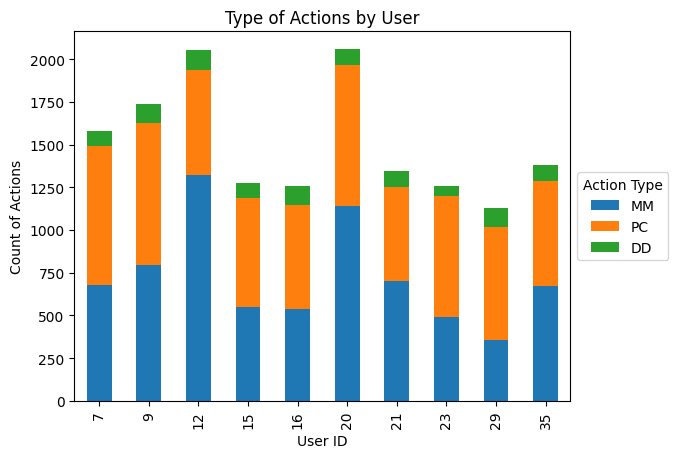

In [83]:
balabitAnalyser.plotTypeOfActions(True)

The actions are represented by 3 variables:
- MM (Mouse Move action) the user moves the cursor from x1,y1 to x2,y2 point, 
- PC (Process and Click action) the user moves the cursor from x1,y1 point to x2,y2 point and then proceeds to click the mouse,
- DD (Drag and drop action) the user drags something from first point to another one.

# BALABIT TEACHING THE MODELS ##
## Supervised part:
RandomForest and SVM 


In [84]:
from RandomForestModel import *


User 7 is being analyzed:
CV Accuracy: 0.93 (+/- 0.03)
Test Accuracy: 0.85
7: 0.940 threshold: 0.471
7: Average Precision: 0.899508239599626
User 9 is being analyzed:
CV Accuracy: 0.95 (+/- 0.03)
Test Accuracy: 0.92
9: 0.983 threshold: 0.575
9: Average Precision: 0.9835749328414888
User 12 is being analyzed:
CV Accuracy: 0.76 (+/- 0.05)
Test Accuracy: 0.68
12: 0.795 threshold: 0.482
12: Average Precision: 0.759136273324283
User 15 is being analyzed:
CV Accuracy: 0.75 (+/- 0.05)
Test Accuracy: 0.74
15: 0.815 threshold: 0.525
15: Average Precision: 0.8022429990324409
User 16 is being analyzed:
CV Accuracy: 0.73 (+/- 0.05)
Test Accuracy: 0.67
16: 0.755 threshold: 0.496
16: Average Precision: 0.7112582453045257
User 20 is being analyzed:
CV Accuracy: 0.85 (+/- 0.03)
Test Accuracy: 0.81
20: 0.888 threshold: 0.493
20: Average Precision: 0.8871305437118323
User 21 is being analyzed:
CV Accuracy: 0.77 (+/- 0.06)
Test Accuracy: 0.73
21: 0.808 threshold: 0.536
21: Average Precision: 0.7824160146

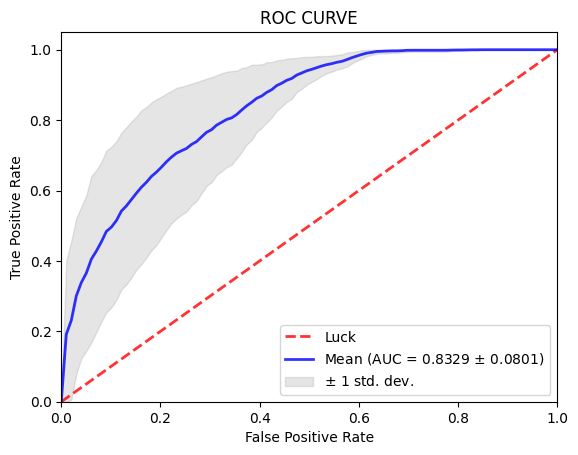

In [24]:
shuffle = True
fpr = {}
tpr = {}
roc_auc = {}
precision = {}
recall = {}
average_precision = {}
balanced = True
for legalUser in users:
    dataset = balabitAnalyser.createTrainingDataWithLabel(legalUser, balanced = balanced)
    X = dataset[:, 0:-1]
    y = dataset[:, -1]

    
    X_train, X_validation, y_train, y_validation = balabitAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = RandomForestModel(dataset, users)
    ## evaluating the model, the variables are X_train, y_train, X_validation, y_validation, scale --> use standardScler, and legalUser
    fpr[legalUser], tpr[legalUser], thr, precision[legalUser], recall[legalUser], average_precision[legalUser] = model.evaluate(X_train, y_train, X_validation, y_validation, scale = True, user = legalUser, num_actions=1)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## Equal Error Rate //brentq znajdowanie 0 , interpid interpolacja
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
    print(f"{legalUser}: {roc_auc[legalUser]:.3f} threshold: {threshold:.3f}")
    print(f"{legalUser}: Average Precision: {average_precision[legalUser]}")

plotROCs(fpr, tpr, roc_auc, users)

roc_path = f'wykresy\\RF{limit}Balabit_balanced{balanced}ROC'
pr_path = f'wykresy\\RF{limit}Balabit_balanced{balanced}PR'
plotROCs(fpr, tpr, roc_auc, users,False, True, roc_path)
plot_precisions_recalls(precision, recall, average_precision, True, pr_path)

In [4]:
from SVMmodel import *

User 7 is being analyzed:


CV Accuracy: 0.89 (+/- 0.03)
Test Accuracy: 0.88
7: 0.949 threshold: 0.614
7: Average Precision: 0.9408978764263803
User 9 is being analyzed:
CV Accuracy: 0.93 (+/- 0.03)
Test Accuracy: 0.91
9: 0.973 threshold: 0.652
9: Average Precision: 0.9705325906439526
User 12 is being analyzed:
CV Accuracy: 0.74 (+/- 0.05)
Test Accuracy: 0.76
12: 0.832 threshold: 0.556
12: Average Precision: 0.7983570704654792
User 15 is being analyzed:
CV Accuracy: 0.73 (+/- 0.06)
Test Accuracy: 0.72
15: 0.785 threshold: 0.591
15: Average Precision: 0.7485298531873843
User 16 is being analyzed:
CV Accuracy: 0.69 (+/- 0.05)
Test Accuracy: 0.70
16: 0.757 threshold: 0.609
16: Average Precision: 0.7162362725659711
User 20 is being analyzed:
CV Accuracy: 0.82 (+/- 0.03)
Test Accuracy: 0.86
20: 0.867 threshold: 0.601
20: Average Precision: 0.8222756315403918
User 21 is being analyzed:
CV Accuracy: 0.74 (+/- 0.05)
Test Accuracy: 0.72
21: 0.834 threshold: 0.646
21: Average Precision: 0.7863828657304597
User 23 is being 

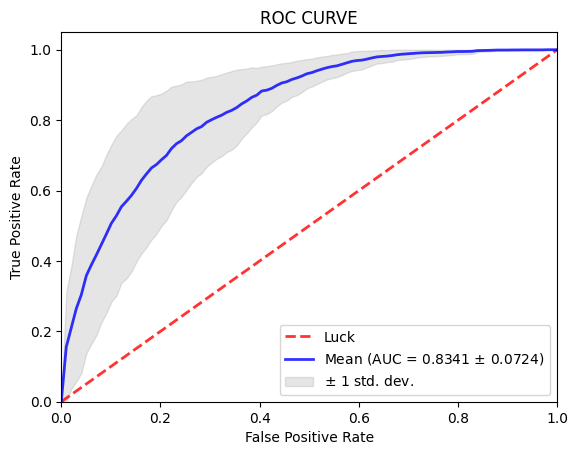

In [5]:
# shuffle var will be used later in order to mix the data ## 
shuffle = True
## dictionaries of fpr tpr ## 
fpr = {}
tpr = {}
roc_auc = {}
precision = {}
recall = {}
average_precision = {}
balanced = True
# ONE USER IS ALWAYS LEGAL ##
for legalUser in users:
    ## this function gets all samples of legaluser and then randomly selects the samples from other users - The data will be balanced ## 
    dataset = balabitAnalyser.createTrainingDataWithLabel(legalUser, balanced = balanced)
    ## the last label is 1 or -1
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    ## train test split --> shuffle is used there ## if not used then data will be divided as x[0:halfTrainSamples] concatenate with X[positiveSamples: positiveSamples + trainHalfSamples]
    ## where positiveSamples is len(X/2)
    
    X_train, X_validation, y_train, y_validation = balabitAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = SVMModel(dataset, users)
    ## evaluating the model, the variables are X_train, y_train, X_validation, y_validation, scale --> use standardScler, and legalUser
    fpr[legalUser], tpr[legalUser], thr, precision[legalUser], recall[legalUser], average_precision[legalUser] = model.evaluate(X_train, y_train, X_validation, y_validation, user = legalUser, num_actions=1)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## Equal Error Rate //brentq znajdowanie 0 , interpid interpolacja
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
    print(f"{legalUser}: {roc_auc[legalUser]:.3f} threshold: {threshold:.3f}")
    print(f"{legalUser}: Average Precision: {average_precision[legalUser]}")

plotROCs(fpr, tpr, roc_auc, users)

roc_path = f'wykresy\\SVM{limit}Balabit_balanced{balanced}ROC'
pr_path = f'wykresy\\SVM{limit}Balabit_balanced{balanced}PR'
plotROCs(fpr, tpr, roc_auc, users,False, True, roc_path)
plot_precisions_recalls(precision, recall, average_precision, True, pr_path)


As its visible the results for both of the algorithms are satisfactionary

## Unsupervised  algorithms 
One class SVM and Isolation Forest

## One Class SVM

In [88]:
from OneClassSVMModel import *

User 7 is being analyzed:
Test Accuracy: 0.50
7: 0.9321945074326027 threshold: -0.5009179878931581
User 9 is being analyzed:
Test Accuracy: 0.50
9: 0.7239865790763149 threshold: -0.5031326966309049
User 12 is being analyzed:
Test Accuracy: 0.50
12: 0.8889619274241521 threshold: -0.5013351784198813
User 15 is being analyzed:
Test Accuracy: 0.50
15: 0.6580930411380239 threshold: -0.5051246047240953
User 16 is being analyzed:
Test Accuracy: 0.50
16: 0.8818828272567102 threshold: -0.5018703009943797
User 20 is being analyzed:
Test Accuracy: 0.50
20: 0.9275815321955234 threshold: -0.5022077543153506
User 21 is being analyzed:
Test Accuracy: 0.50
21: 0.8128271886834485 threshold: -0.5025449445467456
User 23 is being analyzed:
Test Accuracy: 0.50
23: 0.8233043919937778 threshold: -0.5022633585350025
User 29 is being analyzed:
Test Accuracy: 0.50
29: 0.7693241444122484 threshold: -0.5030268390042245
User 35 is being analyzed:
Test Accuracy: 0.50
35: 0.8661192501575301 threshold: -0.50110560371

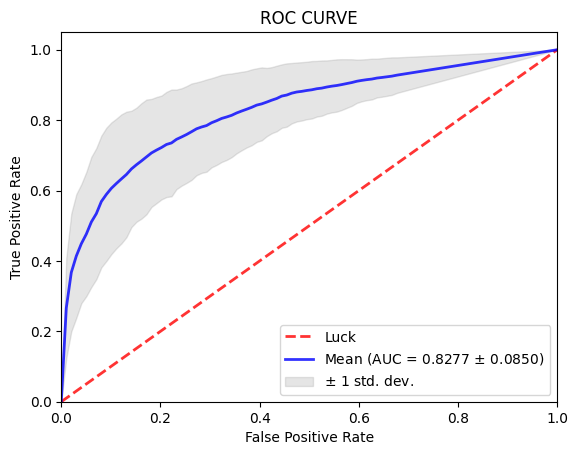

In [89]:
fpr = {}
tpr = {}
roc_auc = {}
shuffle = False
precision = {}
recall = {}
average_precision = {}
balanced = True
for legalUser in users:
    dataset = balabitAnalyser.createTrainingDataWithLabel(legalUser)
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    
    x_negative = X[y == 0]
    x_positive = X[y == 1] 

    X_train, X_validation, y_train, y_validation = balabitAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    y_validation = np.where(y_validation == 0, -1, y_validation)

    model = OneClassSVMModel(dataset, users, nu = 0.5, kernel="rbf", gamma = 5)
    fpr[legalUser], tpr[legalUser], thr, precision[legalUser],  recall[legalUser],  average_precision[legalUser] = model.evaluate(x_positive, y_train, X_validation, y_validation, legalUser)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja 
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
  
    print(str(legalUser) + ": " + str(roc_auc[legalUser])+" threshold: "+str(threshold))

plotROCs(fpr, tpr, roc_auc, users)


roc_path = f'wykresy\\OCSVM{limit}Balabit_balanced{balanced}ROC'
pr_path = f'wykresy\\OCSVM{limit}Balabit_balanced{balanced}PR'
plotROCs(fpr, tpr, roc_auc, users,False, True, roc_path)
plot_precisions_recalls(precision, recall, average_precision, True, pr_path)


## Isolation Forest

In [90]:
from IsolationForestModel import *

User 7 is being analyzed:
Test Accuracy: 0.51
7: 0.3710657596371882 threshold: 0.05400382690145894
User 9 is being analyzed:
Test Accuracy: 0.57
9: 0.6245048127631656 threshold: 0.02574932528908863
User 12 is being analyzed:
Test Accuracy: 0.57
12: 0.6858239143367043 threshold: 0.034382596984059655
User 15 is being analyzed:
Test Accuracy: 0.50
15: 0.5132487504805843 threshold: 0.025066724603283467
User 16 is being analyzed:
Test Accuracy: 0.54
16: 0.653846764337074 threshold: 0.037357963669919794
User 20 is being analyzed:
Test Accuracy: 0.51
20: 0.47982192859383976 threshold: 0.033545325381125535
User 21 is being analyzed:
Test Accuracy: 0.57
21: 0.6400646023613277 threshold: 0.024447952951928736
User 23 is being analyzed:
Test Accuracy: 0.65
23: 0.6965286265297376 threshold: 0.015223800778160138
User 29 is being analyzed:
Test Accuracy: 0.47
29: 0.45790586576865844 threshold: 0.03948533228920024
User 35 is being analyzed:
Test Accuracy: 0.57
35: 0.7311751732829237 threshold: 0.05367

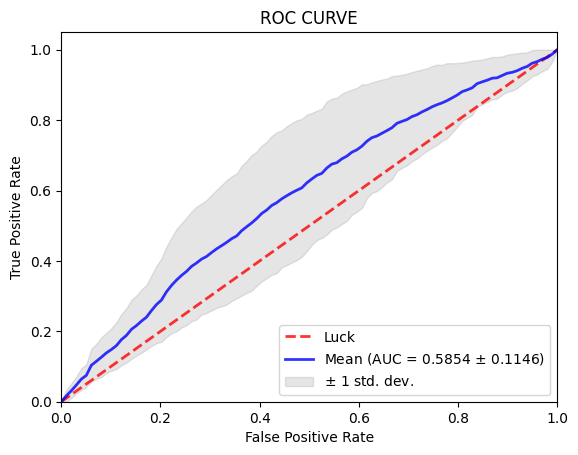

In [91]:
tpr = {}
roc_auc = {}
shuffle = False
precision = {}
recall = {}
average_precision = {}
balanced = True
fpr = {}

for legalUser in users:
    dataset = balabitAnalyser.createTrainingDataWithLabel(legalUser)
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    
    x_negative = X[y == 0]
    x_positive = X[y == 1] 

    X_train, X_validation, y_train, y_validation = balabitAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    y_validation = np.where(y_validation == 0, -1, y_validation)

    model = IsolationForestModel(dataset, users)
    fpr[legalUser], tpr[legalUser], thr, precision[legalUser],  recall[legalUser],  average_precision[legalUser] = model.evaluate(x_positive, y_train, X_validation, y_validation, legalUser)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja 
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
  
    print(str(legalUser) + ": " + str(roc_auc[legalUser])+" threshold: "+str(threshold))

plotROCs(fpr, tpr, roc_auc, users)


roc_path = f'wykresy\\IF{limit}Balabit_balanced{balanced}ROC'
pr_path = f'wykresy\\IF{limit}Balabit_balanced{balanced}PR'
plotROCs(fpr, tpr, roc_auc, users,False, True, roc_path)
plot_precisions_recalls(precision, recall, average_precision, True, pr_path)


Using unsupervised algorithms doesn't yeald better results.

# Checking which features are important for Random Forest
# Feature importance method

In [6]:
## choose legalUser randomly and create dataset for him ## 
legalUser = random.choice(users)
dataset = balabitAnalyser.createTrainingDataWithLabel(legalUser)
X = dataset[:, 0:-1]
y = dataset[:, -1]
X_train, X_validation, y_train, y_validation = balabitAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
model = RandomForestModel(dataset, users)
feature_importance = model.calculateFeatureImportance(X_train, y_train, X_validation)
df1 = balabitAnalyser.returnDataframe()


In [7]:
final = 0
i = 0
shuffle = True
for legalUser in users:
    dataset = balabitAnalyser.createTrainingDataWithLabel(legalUser)
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    X_train, X_validation, y_train, y_validation = balabitAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = RandomForestModel(dataset, users)
    feature_importance = model.calculateFeatureImportance(X_train, y_train, X_validation)
    final+=feature_importance
    i+=1

final = final/i
df1 = balabitAnalyser.returnDataframe()

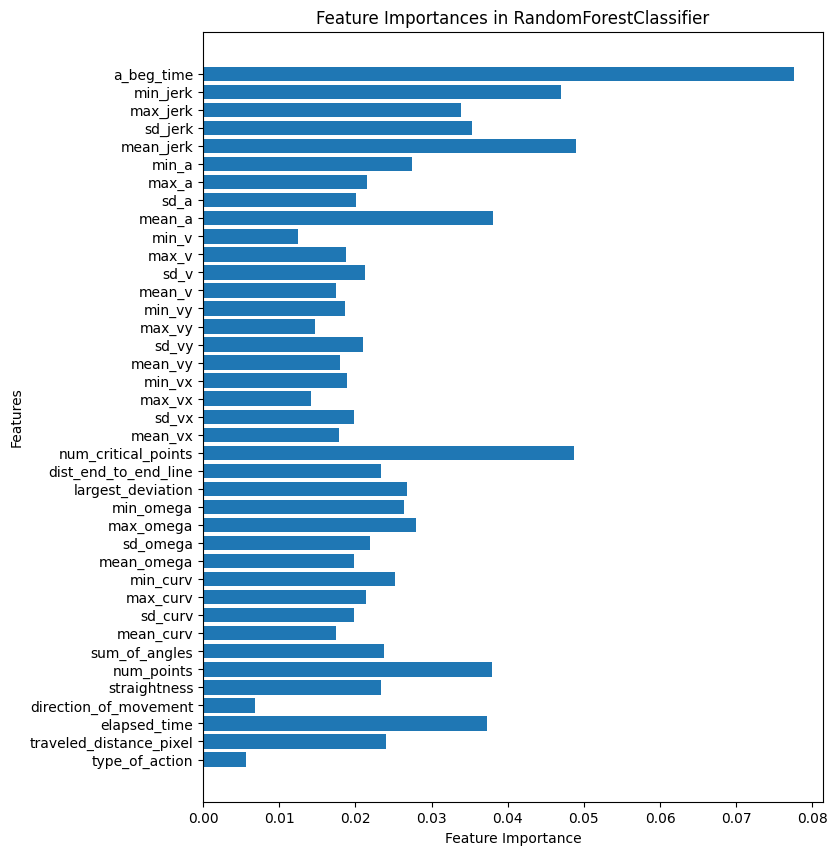

In [8]:
model.plotFeatureImportance(final, X, df1)

## Permutation Importance method

In [9]:
final = 0
i = 0
for legalUser in users:
    dataset = balabitAnalyser.createTrainingDataWithLabel(legalUser)
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    X_train, X_validation, y_train, y_validation = balabitAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = RandomForestModel(dataset, users)
    permutationImportance = model.calculatePermutationImportance(X_train, y_train, X_validation, y_validation)
    final+=permutationImportance
    i+=1

final = final/i
df1 = balabitAnalyser.returnDataframe()

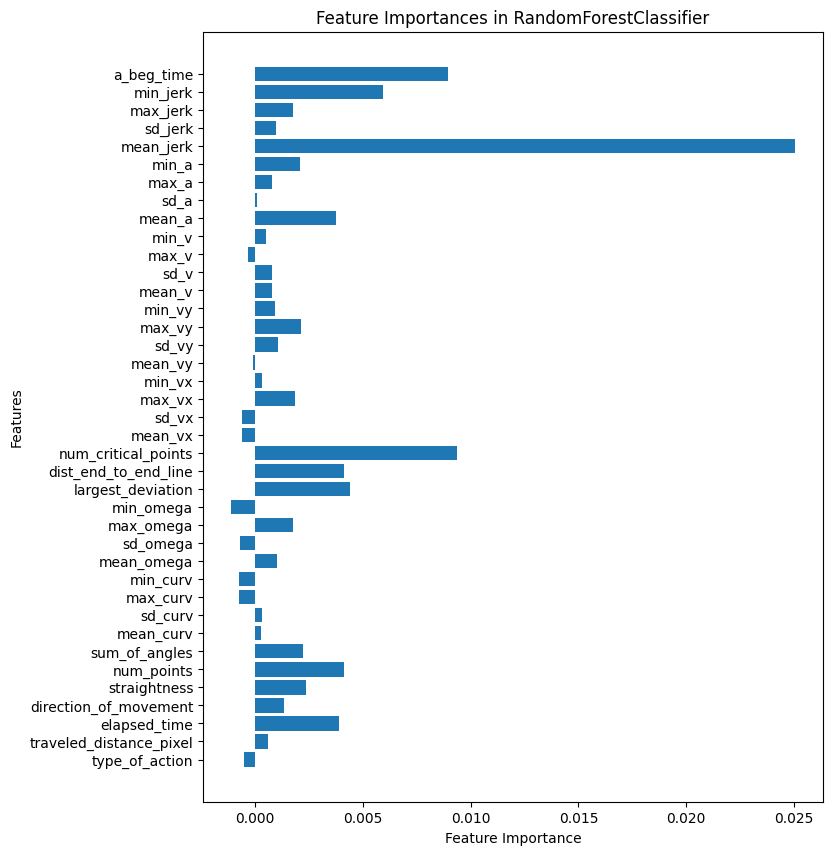

In [10]:
# permutationImportance = model.calculatePermutationImportance(X_train, y_train, X_validation, y_validation)
model.plotFeatureImportance(final, X, df1)

## SVM

In [11]:
## choose legalUser randomly and create dataset for him ## 
legalUser = random.choice(users)
dataset = balabitAnalyser.createTrainingDataWithLabel(legalUser)
X = dataset[:, 0:-1]
y = dataset[:, -1]
shuffle = False
X_train, X_validation, y_train, y_validation = balabitAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
model = SVMModel(dataset, users)
df1 = balabitAnalyser.returnDataframe()


In [12]:
final = 0
i = 0
for legalUser in users:
    dataset = balabitAnalyser.createTrainingDataWithLabel(legalUser)
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    X_train, X_validation, y_train, y_validation = balabitAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = SVMModel(dataset, users)
    permutationImportance = model.calculatePermutationImportance(X_train, y_train, X_validation, y_validation)
    final+=permutationImportance
    i+=1

final = final/i
df1 = balabitAnalyser.returnDataframe()

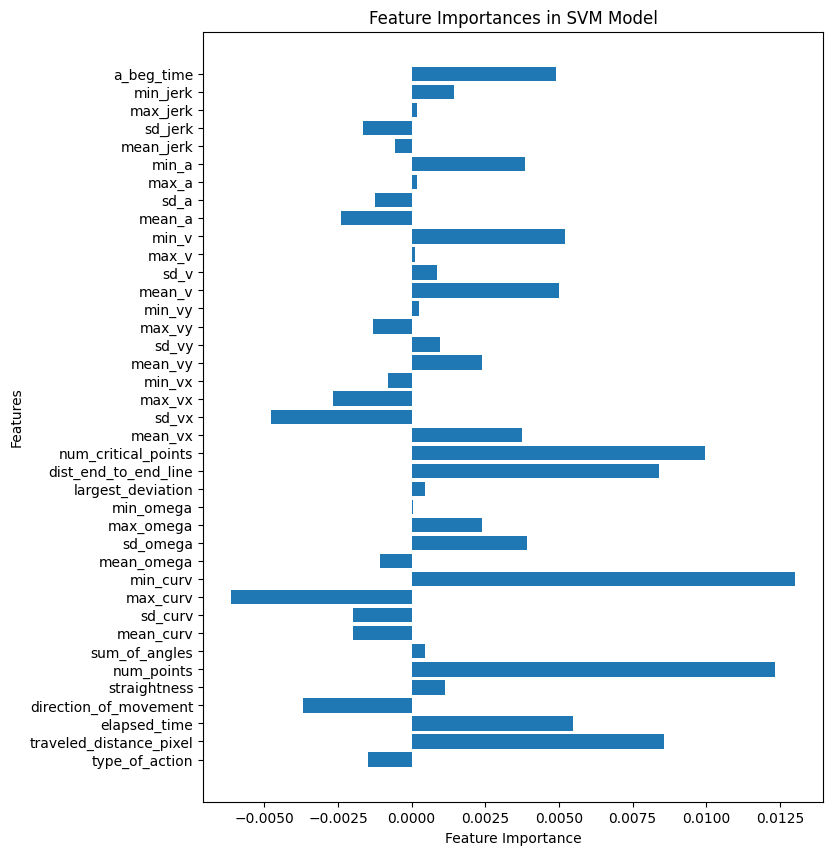

In [13]:
model.plotFeatureImportance(permutationImportance, X, df1)

The most importants variables are :
- a_beg_time (acceleration in the begginng),
- jerk variables,
- number_of_critical_points (the amount of times the mouse is changing the direction)
- acceleration,
- straightness.

It all depends on the user, yet summarazing those are the ones which contribute the most.

#

# Creating datasets using the test files too  (works only for BALABIT) 
Labeling is being done during feature extraction and not in the end  of the process 

## Random Forest

In [60]:
users = [7,9,15,16,20,21,23,29, 35]
balabit_reader = DataReaderBalabit(BALABIT, users, True, limit = 1000) ## the arguments are DATASET, users, supervised = True, how many records should be procesed ##

File already exist
User 7 is being analyzed:
CV Accuracy: 0.93 (+/- 0.03)
Test Accuracy: 0.93
7: 1.000 threshold: 0.530
File already exist
User 9 is being analyzed:
CV Accuracy: 0.96 (+/- 0.02)
Test Accuracy: 0.79
9: 1.000 threshold: 0.354
File already exist
User 15 is being analyzed:
CV Accuracy: 0.72 (+/- 0.06)
Test Accuracy: 0.71
15: 0.937 threshold: 0.535
File already exist
User 16 is being analyzed:
CV Accuracy: 0.68 (+/- 0.03)
Test Accuracy: 0.67
16: 0.926 threshold: 0.597
File already exist
User 20 is being analyzed:
CV Accuracy: 0.84 (+/- 0.19)
Test Accuracy: 0.75
20: 0.849 threshold: 0.394
File already exist
User 21 is being analyzed:
CV Accuracy: 0.71 (+/- 0.07)
Test Accuracy: 0.67
21: 0.944 threshold: 0.503
File already exist
User 23 is being analyzed:
CV Accuracy: 0.71 (+/- 0.08)
Test Accuracy: 0.66
23: 0.935 threshold: 0.485
File already exist
User 29 is being analyzed:
CV Accuracy: 0.76 (+/- 0.16)
Test Accuracy: 0.73
29: 0.950 threshold: 0.492
File already exist
User 35 i

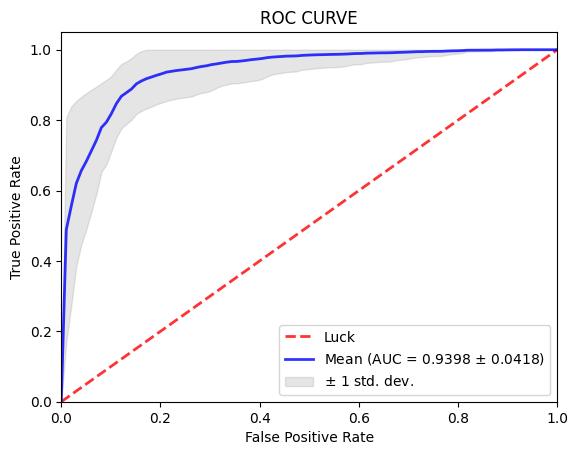

In [61]:
tpr = {}
roc_auc = {}
shuffle = False
precision = {}
recall = {}
average_precision = {}
balanced = True
fpr = {}

for legalUser in users:
    # the function below has 3 variables - legalser (which of the sessions are legal), training - use training files only, test - use test files and parse CSV to check the legality ##
    balabit_reader.processDataWithLabels(legalUser, training = True, test = True)
    # the rest is the same as in previous attempts ##
    path = balabit_reader.getFileName()
    legality_analyser = legalityAnalyser(path)
    ## balanced = True - it will create balanced dataset // when balanced is False then  every false action of the dataset will be used, ratio legal to illegal will be  something like 1:8 
    dataset = legality_analyser.createTrainingData(balanced = True)

    ## the last label is 0 and 1
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
   
    X_train, X_validation, y_train, y_validation = legality_analyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = RandomForestModel(dataset, users)
    ## evaluating the model, the variables are X_train, y_train, X_validation, y_validation, scale --> use standardScler, and legalUser
    fpr[legalUser], tpr[legalUser], thr, precision[legalUser], recall[legalUser], average_precision[legalUser] = model.evaluate(X_train, y_train, X_validation, y_validation, scale = True, user = legalUser)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
    print(f"{legalUser}: {roc_auc[legalUser]:.3f} threshold: {threshold:.3f}")

plotROCs(fpr, tpr, roc_auc, users)

## SVM

File already exist
User 7 is being analyzed:
CV Accuracy: 0.88 (+/- 0.03)
Test Accuracy: 0.89
7: 0.999 threshold: 0.559
File already exist
User 9 is being analyzed:
CV Accuracy: 0.91 (+/- 0.04)
Test Accuracy: 0.92
9: 1.000 threshold: 0.512
File already exist
User 15 is being analyzed:
CV Accuracy: 0.69 (+/- 0.04)
Test Accuracy: 0.67
15: 0.915 threshold: 0.518
File already exist
User 16 is being analyzed:
CV Accuracy: 0.64 (+/- 0.04)
Test Accuracy: 0.66
16: 0.874 threshold: 0.536
File already exist
User 20 is being analyzed:
CV Accuracy: 0.79 (+/- 0.04)
Test Accuracy: 0.78
20: 0.969 threshold: 0.493
File already exist
User 21 is being analyzed:
CV Accuracy: 0.66 (+/- 0.05)
Test Accuracy: 0.66
21: 0.904 threshold: 0.518
File already exist
User 23 is being analyzed:
CV Accuracy: 0.66 (+/- 0.04)
Test Accuracy: 0.69
23: 0.894 threshold: 0.497
File already exist
User 29 is being analyzed:
CV Accuracy: 0.72 (+/- 0.04)
Test Accuracy: 0.73
29: 0.955 threshold: 0.515
File already exist
User 35 i

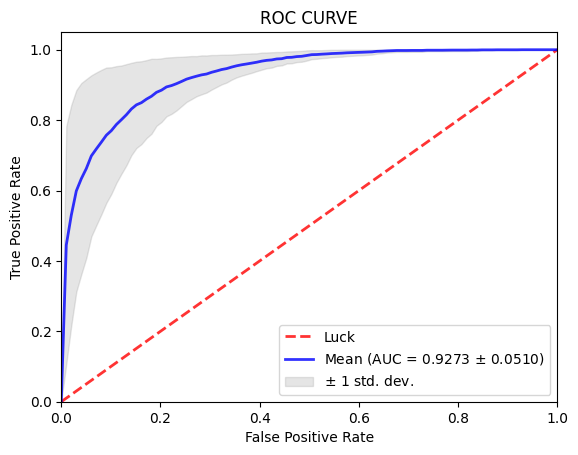

In [20]:
tpr = {}
roc_auc = {}
shuffle = False
precision = {}
recall = {}
average_precision = {}
balanced = True
fpr = {}

for legalUser in users:
    # the function below has 3 variables - legalser (which of the sessions are legal), training - use training files only, test - use test files and parse CSV to check the legality ##
    balabit_reader.processDataWithLabels(legalUser, training = True, test = True)
    # the rest is the same as in previous attempts ##
    path = balabit_reader.getFileName()
    legality_analyser = legalityAnalyser(path)
    ## balanced = True - it will create balanced dataset // when balanced is False then  every false action of the dataset will be used, ratio legal to illegal will be  something like 1:8 
    dataset = legality_analyser.createTrainingData(balanced = True)

    ## the last label is 0 and 1
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
   
    X_train, X_validation, y_train, y_validation = legality_analyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = SVMModel(dataset, users)
    ## evaluating the model, the variables are X_train, y_train, X_validation, y_validation, scale --> use standardScler, and legalUser
    fpr[legalUser], tpr[legalUser], thr = model.evaluate(X_train, y_train, X_validation, y_validation, user = legalUser)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
    print(f"{legalUser}: {roc_auc[legalUser]:.3f} threshold: {threshold:.3f}")

plotROCs(fpr, tpr, roc_auc, users)

# CHAOSHEN

In [92]:
from utils.consts import *
from utils. plotting import *
from data_reader_chaoshen import *
from nonlegality_analyser import *
import random

In [126]:
# users = [1,2, 3, 5, 4,16,20,21,23] # a few users
limit = 100000000
users = [i for i in range (1,29)] ## all users 
chaoshen_reader = DataReaderChaoShen(CHAOSHEN, users, limit = limit)
chaoshen_reader.processDataWithoutLabels()

In [94]:

path = chaoshen_reader.getFileName()
chaoShenAnalyser = nonLegalityAnalyser(path)
print(chaoShenAnalyser.countActions())

type_of_action     1    3    4
userid                        
1                426  494  214
2                721  155  334
3                498  422  174
4                713  462  149
5               1080  411  168
6                776  472  167
7                558  412  269
8                576  485  160
9                622  436  146
10               838  279  257
11               826  394  181
12              2232  360  176
13               944  330  132
14               756  340  172
15               576  470  151
16               763  401  166
17               575  455  156
18               812  400  125
19              1013  440  107
20               656  233  155
21               688  212  131
22               787  218  246
23               513  478  239
24               559  406  301
25               657  441  248
26               622  325  314
27               553  418  239
28               860  419  153


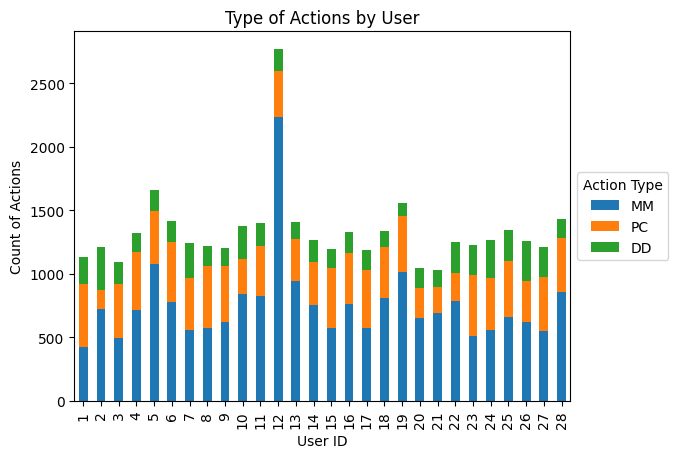

In [95]:
chaoShenAnalyser.plotTypeOfActions(True)

## Random Forest

In [96]:
from RandomForestModel import *

User 1 is being analyzed:
CV Accuracy: 0.72 (+/- 0.16)
Test Accuracy: 0.79
1: 0.878 threshold: 0.520
User 2 is being analyzed:
CV Accuracy: 0.77 (+/- 0.20)
Test Accuracy: 0.72
2: 0.813 threshold: 0.406
User 3 is being analyzed:
CV Accuracy: 0.73 (+/- 0.10)
Test Accuracy: 0.75
3: 0.847 threshold: 0.535
User 4 is being analyzed:
CV Accuracy: 0.68 (+/- 0.09)
Test Accuracy: 0.71
4: 0.785 threshold: 0.513
User 5 is being analyzed:
CV Accuracy: 0.75 (+/- 0.08)
Test Accuracy: 0.60
5: 0.663 threshold: 0.405
User 6 is being analyzed:
CV Accuracy: 0.70 (+/- 0.11)
Test Accuracy: 0.71
6: 0.789 threshold: 0.490
User 7 is being analyzed:
CV Accuracy: 0.74 (+/- 0.07)
Test Accuracy: 0.73
7: 0.815 threshold: 0.497
User 8 is being analyzed:
CV Accuracy: 0.73 (+/- 0.08)
Test Accuracy: 0.72
8: 0.783 threshold: 0.525
User 9 is being analyzed:
CV Accuracy: 0.65 (+/- 0.08)
Test Accuracy: 0.65
9: 0.726 threshold: 0.491
User 10 is being analyzed:
CV Accuracy: 0.68 (+/- 0.11)
Test Accuracy: 0.74
10: 0.802 thres

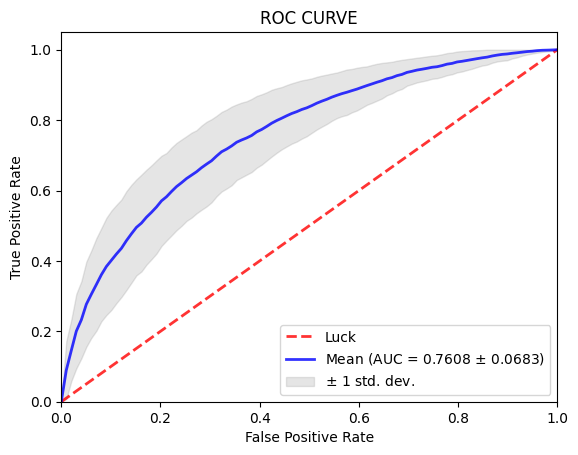

In [97]:
tpr = {}
roc_auc = {}
shuffle = False
precision = {}
recall = {}
average_precision = {}
balanced = True
fpr = {}

for legalUser in users:
    dataset = chaoShenAnalyser.createTrainingDataWithLabel(legalUser)
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    X_train, X_validation, y_train, y_validation = chaoShenAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = RandomForestModel(dataset, users)
    fpr[legalUser], tpr[legalUser], thr, precision[legalUser], recall[legalUser], average_precision[legalUser] = model.evaluate(X_train, y_train, X_validation, y_validation, scale = False, user = legalUser, num_actions=1)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
    print(f"{legalUser}: {roc_auc[legalUser]:.3f} threshold: {threshold:.3f}")

plotROCs(fpr, tpr, roc_auc, users)


roc_path = f'wykresy\\RF{limit}chaoshen_balanced{balanced}ROC'
pr_path = f'wykresy\\RF{limit}chaoshen_balanced{balanced}PR'
plotROCs(fpr, tpr, roc_auc, users,False, True, roc_path)
plot_precisions_recalls(precision, recall, average_precision, True, pr_path)

## SVM

User 1 is being analyzed:
CV Accuracy: 0.69 (+/- 0.12)
Test Accuracy: 0.68
1: 0.750 threshold: 0.523
User 2 is being analyzed:
CV Accuracy: 0.75 (+/- 0.17)
Test Accuracy: 0.63
2: 0.695 threshold: 0.501
User 3 is being analyzed:
CV Accuracy: 0.65 (+/- 0.10)
Test Accuracy: 0.64
3: 0.690 threshold: 0.542
User 4 is being analyzed:
CV Accuracy: 0.60 (+/- 0.06)
Test Accuracy: 0.66
4: 0.728 threshold: 0.504
User 5 is being analyzed:
CV Accuracy: 0.65 (+/- 0.09)
Test Accuracy: 0.70
5: 0.617 threshold: 0.505
User 6 is being analyzed:
CV Accuracy: 0.61 (+/- 0.21)
Test Accuracy: 0.57
6: 0.606 threshold: 0.465
User 7 is being analyzed:
CV Accuracy: 0.63 (+/- 0.10)
Test Accuracy: 0.62
7: 0.675 threshold: 0.559
User 8 is being analyzed:
CV Accuracy: 0.67 (+/- 0.06)
Test Accuracy: 0.65
8: 0.693 threshold: 0.501
User 9 is being analyzed:
CV Accuracy: 0.62 (+/- 0.07)
Test Accuracy: 0.61
9: 0.678 threshold: 0.535
User 10 is being analyzed:
CV Accuracy: 0.65 (+/- 0.05)
Test Accuracy: 0.66
10: 0.703 thres

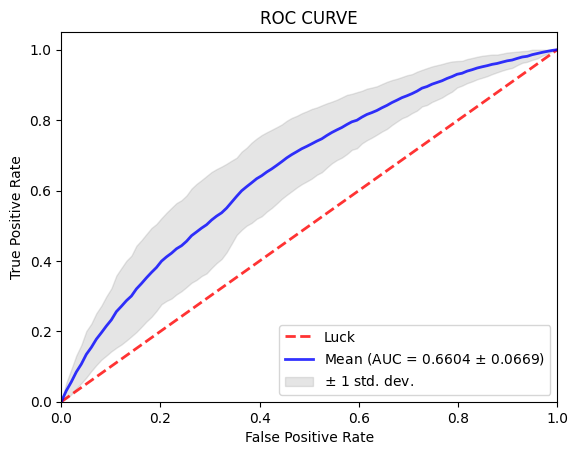

In [98]:
tpr = {}
roc_auc = {}
shuffle = False
precision = {}
recall = {}
average_precision = {}
balanced = True
fpr = {}
for legalUser in users:
    dataset = chaoShenAnalyser.createTrainingDataWithLabel(legalUser)    
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    X_train, X_validation, y_train, y_validation = chaoShenAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = SVMModel(dataset, users, kernel = 'rbf', C= 10)
    fpr[legalUser], tpr[legalUser], thr, precision[legalUser], recall[legalUser], average_precision[legalUser] = model.evaluate(X_train, y_train, X_validation, y_validation, user = legalUser, num_actions=1)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
    print(f"{legalUser}: {roc_auc[legalUser]:.3f} threshold: {threshold:.3f}")


plotROCs(fpr, tpr, roc_auc, users)



roc_path = f'wykresy\\SVM{limit}chaoshen_balanced{balanced}ROC'
pr_path = f'wykresy\\SVM{limit}chaoshen_balanced{balanced}PR'
plotROCs(fpr, tpr, roc_auc, users,False, True, roc_path)
plot_precisions_recalls(precision, recall, average_precision, True, pr_path)

## OC SVM

User 1 is being analyzed:
Test Accuracy: 0.50
1: 0.8704479599028898 threshold: -0.5221794278471006
User 2 is being analyzed:
Test Accuracy: 0.50
2: 0.6509288982992963 threshold: -0.716468306258494
User 3 is being analyzed:
Test Accuracy: 0.50
3: 0.8623327161013384 threshold: -0.5804125009350029
User 4 is being analyzed:
Test Accuracy: 0.50
4: 0.8618715564738291 threshold: -0.5456311402977179
User 5 is being analyzed:
Test Accuracy: 0.50
5: 0.8116574328456294 threshold: -0.6336330966620184
User 6 is being analyzed:
Test Accuracy: 0.50
6: 0.8809449487445217 threshold: -0.6453039028744144
User 7 is being analyzed:
Test Accuracy: 0.50
7: 0.8736825714238883 threshold: -0.5486950585711343
User 8 is being analyzed:
Test Accuracy: 0.50
8: 0.895004703036818 threshold: -0.5613669576618284
User 9 is being analyzed:
Test Accuracy: 0.50
9: 0.8034114583333333 threshold: -0.5263289345634758
User 10 is being analyzed:
Test Accuracy: 0.50
10: 0.8284072140231232 threshold: -0.5279035700430266
User 11 is

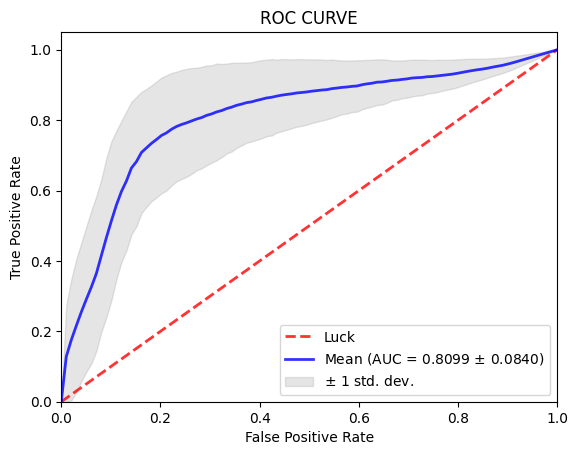

In [99]:
fpr = {}
tpr = {}
roc_auc = {}
shuffle = False
precision = {}
recall = {}
average_precision = {}
balanced = True
for legalUser in users:
    dataset = chaoShenAnalyser.createTrainingDataWithLabel(legalUser)    
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    
    x_negative = X[y == 0]
    x_positive = X[y == 1] 

    X_train, X_validation, y_train, y_validation = chaoShenAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    y_validation = np.where(y_validation == 0, -1, y_validation)

    model = OneClassSVMModel(dataset, users, nu = 0.5, kernel="rbf", gamma = 5)
    fpr[legalUser], tpr[legalUser], thr, precision[legalUser],  recall[legalUser],  average_precision[legalUser] = model.evaluate(x_positive, y_train, X_validation, y_validation, legalUser, num_actions=1)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja 
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
  
    print(str(legalUser) + ": " + str(roc_auc[legalUser])+" threshold: "+str(threshold))

plotROCs(fpr, tpr, roc_auc, users)


roc_path = f'wykresy\\OCSVM{limit}chaoshen_balanced{balanced}ROC'
pr_path = f'wykresy\\OCSVM{limit}chaoshen_balanced{balanced}PR'
plotROCs(fpr, tpr, roc_auc, users,False, True, roc_path)
plot_precisions_recalls(precision, recall, average_precision, True, pr_path)



## IF

User 1 is being analyzed:
Test Accuracy: 0.50
1: 0.49680867726525174 threshold: -0.06922181621455478
User 2 is being analyzed:
Test Accuracy: 0.50
2: 0.4741479407144321 threshold: -0.060583587492613084
User 3 is being analyzed:
Test Accuracy: 0.50
3: 0.5161392138708862 threshold: -0.059461377613961044
User 4 is being analyzed:
Test Accuracy: 0.50
4: 0.5400883838383839 threshold: -0.0637544026800854
User 5 is being analyzed:
Test Accuracy: 0.50
5: 0.7902629585345151 threshold: -0.024057558820829526
User 6 is being analyzed:
Test Accuracy: 0.50
6: 0.5597897339210129 threshold: -0.037251792323477737
User 7 is being analyzed:
Test Accuracy: 0.50
7: 0.577250897408579 threshold: -0.03656497526290528
User 8 is being analyzed:
Test Accuracy: 0.50
8: 0.6236898683149692 threshold: -0.03383734848652489
User 9 is being analyzed:
Test Accuracy: 0.50
9: 0.5462934027777777 threshold: -0.021104363565043388
User 10 is being analyzed:
Test Accuracy: 0.50
10: 0.5238158665885236 threshold: -0.073833031479

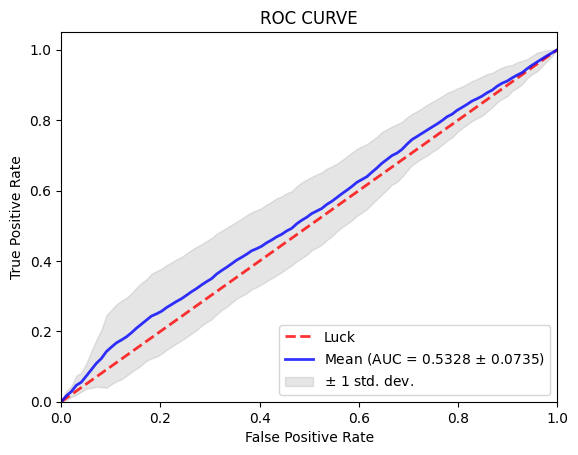

In [100]:
fpr = {}
tpr = {}
roc_auc = {}
shuffle = False
precision = {}
recall = {}
average_precision = {}
balanced = True
for legalUser in users:
    dataset = chaoShenAnalyser.createTrainingDataWithLabel(legalUser)    
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    
    x_negative = X[y == 0]
    x_positive = X[y == 1] 

    X_train, X_validation, y_train, y_validation = chaoShenAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    y_validation = np.where(y_validation == 0, -1, y_validation)

    model = IsolationForestModel(dataset, users, contamination= 0.5, n_estimators=200)
    fpr[legalUser], tpr[legalUser], thr, precision[legalUser],  recall[legalUser],  average_precision[legalUser] = model.evaluate(x_positive, y_train, X_validation, y_validation, legalUser)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja 
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
  
    print(str(legalUser) + ": " + str(roc_auc[legalUser])+" threshold: "+str(threshold))

plotROCs(fpr, tpr, roc_auc, users)


roc_path = f'wykresy\\IF{limit}chaoshen_balanced{balanced}ROC'
pr_path = f'wykresy\\IF{limit}chaoshen_balanced{balanced}PR'
plotROCs(fpr, tpr, roc_auc, users,False, True, roc_path)
plot_precisions_recalls(precision, recall, average_precision, True, pr_path)


# SINGAPUR

In [2]:
from utils.consts import *
from utils. plotting import *
from data_reader_singapur import *
from nonlegality_analyser import *

In [3]:
# users = [1,2, 3, 4, 5, 6,9, 7, 16,20,21,23]
limit = 100000000
users = [i for i in range (1,25)]
singapur_reader = DataReaderSingapur(SINGAPUR, users, limit = limit)


In [4]:
singapur_reader.processDataWithoutLabels()

In [104]:

path = singapur_reader.getFileName()
singapurAnalyser = nonLegalityAnalyser(path)
print(singapurAnalyser.countActions())

type_of_action    1    3    4
userid                       
1               588  649  286
2               291  854  119
3               240  571   78
4               136  431   51
5                77  171   25
6               346  634  150
7               459  750  223
8                94  518   30
9               196  216  110
10              230  409   78
11              124  459   13
12              204  594  127
13              166  408   75
14              489  843  103
15              201  269   71
16              393  436  266
17              397  569  163
18              205  467  117
19              291  541  117
20              378  753  216
21              372  854  104
22              190  379  102
23              165  368   90
24              134  179   20


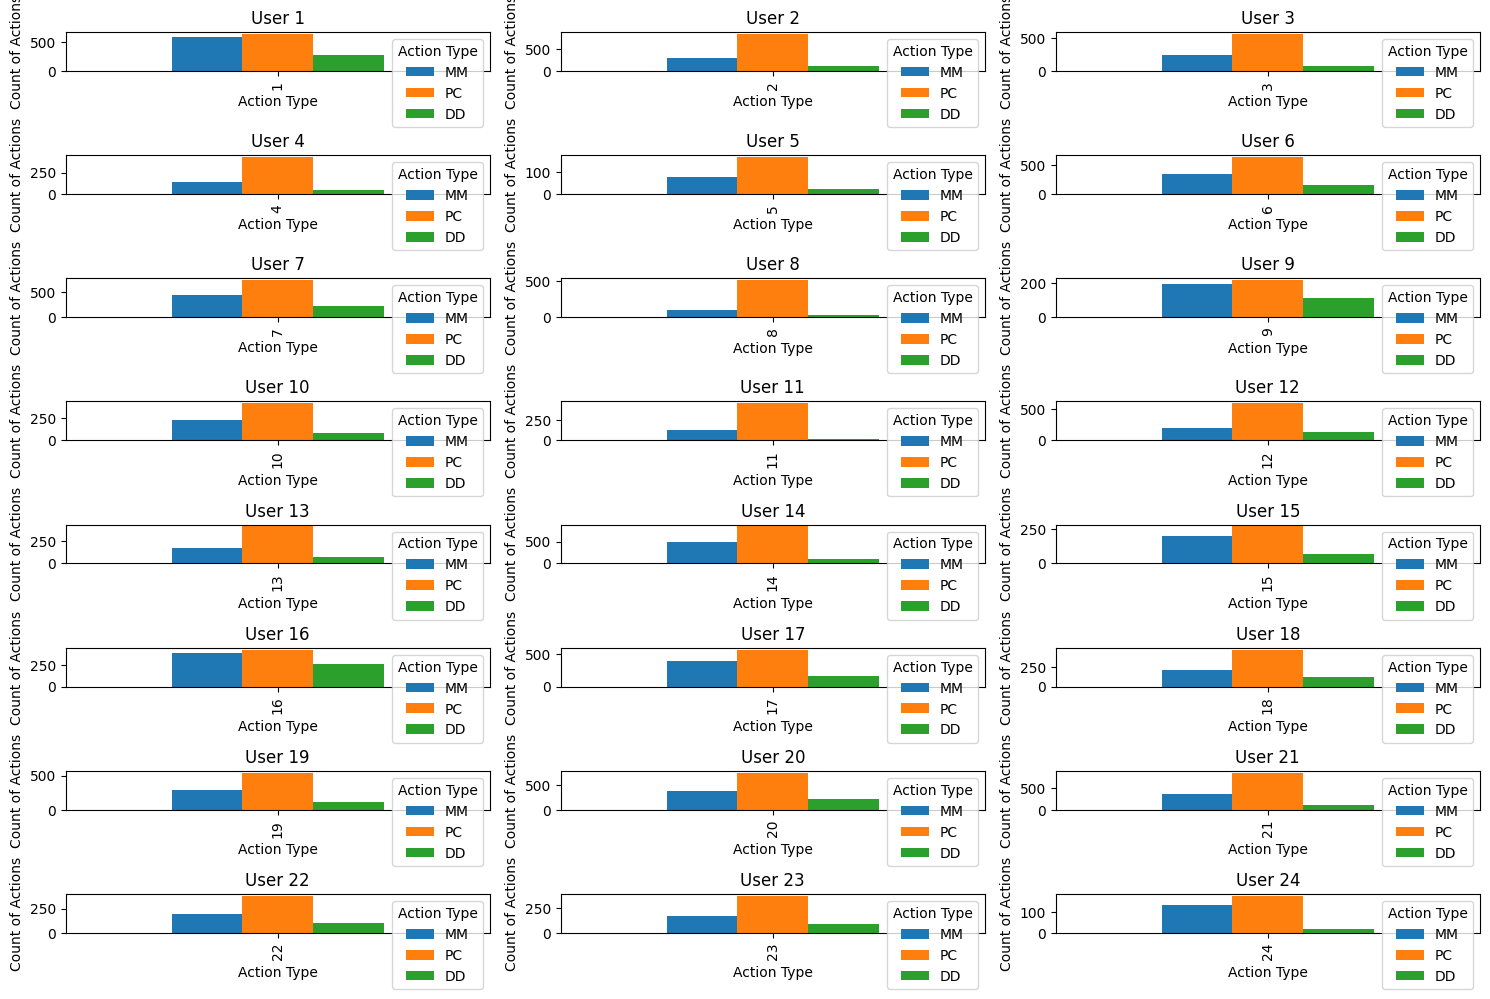

In [105]:
singapurAnalyser.plotActionHistograms()

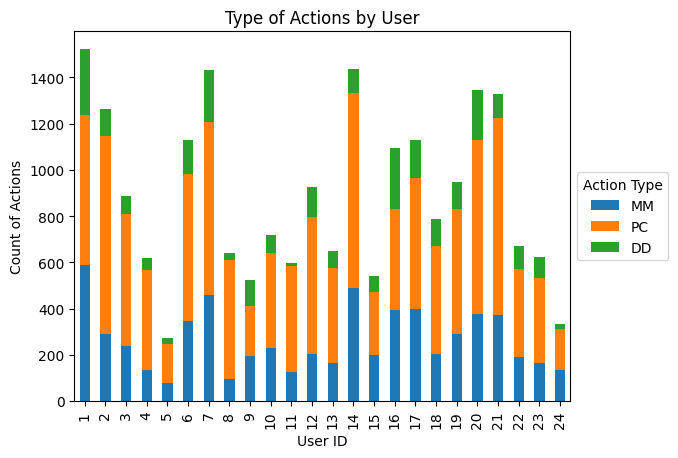

In [106]:
singapurAnalyser.plotTypeOfActions(True)

## Random Forest

In [107]:
from RandomForestModel import *

User 1 is being analyzed:


CV Accuracy: 0.68 (+/- 0.11)
Test Accuracy: 0.77
1: 0.855 threshold: 0.555
User 2 is being analyzed:
CV Accuracy: 0.73 (+/- 0.12)
Test Accuracy: 0.77
2: 0.845 threshold: 0.541
User 3 is being analyzed:
CV Accuracy: 0.70 (+/- 0.07)
Test Accuracy: 0.73
3: 0.791 threshold: 0.500
User 4 is being analyzed:
CV Accuracy: 0.75 (+/- 0.09)
Test Accuracy: 0.76
4: 0.836 threshold: 0.505
User 5 is being analyzed:
CV Accuracy: 0.71 (+/- 0.14)
Test Accuracy: 0.78
5: 0.868 threshold: 0.525
User 6 is being analyzed:
CV Accuracy: 0.67 (+/- 0.07)
Test Accuracy: 0.70
6: 0.767 threshold: 0.538
User 7 is being analyzed:
CV Accuracy: 0.78 (+/- 0.06)
Test Accuracy: 0.78
7: 0.877 threshold: 0.508
User 8 is being analyzed:
CV Accuracy: 0.64 (+/- 0.15)
Test Accuracy: 0.69
8: 0.778 threshold: 0.522
User 9 is being analyzed:
CV Accuracy: 0.75 (+/- 0.12)
Test Accuracy: 0.78
9: 0.850 threshold: 0.499
User 10 is being analyzed:
CV Accuracy: 0.70 (+/- 0.12)
Test Accuracy: 0.73
10: 0.796 threshold: 0.520
User 11 is bei

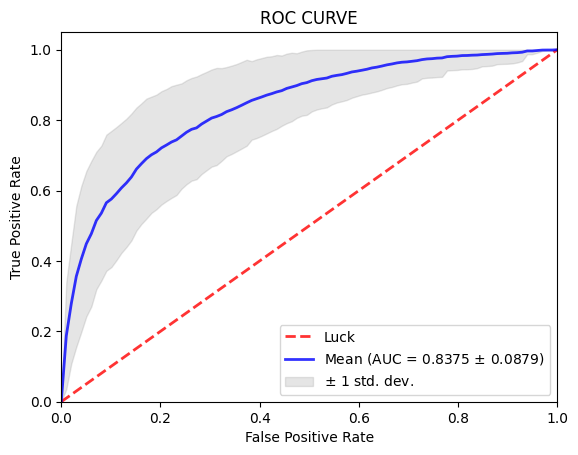

In [108]:
tpr = {}
roc_auc = {}
shuffle = False
precision = {}
recall = {}
average_precision = {}
balanced = True
fpr = {}

for legalUser in users:
    dataset = singapurAnalyser.createTrainingDataWithLabel(legalUser)
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    X_train, X_validation, y_train, y_validation = singapurAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = RandomForestModel(dataset, users)
    fpr[legalUser], tpr[legalUser], thr, precision[legalUser], recall[legalUser], average_precision[legalUser] = model.evaluate(X_train, y_train, X_validation, y_validation, scale = False, user = legalUser, num_actions=1)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
    print(f"{legalUser}: {roc_auc[legalUser]:.3f} threshold: {threshold:.3f}")

plotROCs(fpr, tpr, roc_auc, users)


roc_path = f'wykresy\\RF{limit}singapur_balanced{balanced}ROC'
pr_path = f'wykresy\\RF{limit}singapur_balanced{balanced}PR'
plotROCs(fpr, tpr, roc_auc, users,False, True, roc_path)
plot_precisions_recalls(precision, recall, average_precision, True, pr_path)

## SVM

In [109]:
from SVMmodel import *

User 1 is being analyzed:
CV Accuracy: 0.67 (+/- 0.10)
Test Accuracy: 0.71
1: 0.789 threshold: 0.515
User 2 is being analyzed:
CV Accuracy: 0.69 (+/- 0.10)
Test Accuracy: 0.73
2: 0.799 threshold: 0.520
User 3 is being analyzed:
CV Accuracy: 0.66 (+/- 0.10)
Test Accuracy: 0.66
3: 0.731 threshold: 0.539
User 4 is being analyzed:
CV Accuracy: 0.72 (+/- 0.12)
Test Accuracy: 0.70
4: 0.742 threshold: 0.524
User 5 is being analyzed:
CV Accuracy: 0.70 (+/- 0.18)
Test Accuracy: 0.74
5: 0.845 threshold: 0.586
User 6 is being analyzed:
CV Accuracy: 0.63 (+/- 0.05)
Test Accuracy: 0.66
6: 0.725 threshold: 0.504
User 7 is being analyzed:
CV Accuracy: 0.73 (+/- 0.07)
Test Accuracy: 0.76
7: 0.850 threshold: 0.479
User 8 is being analyzed:
CV Accuracy: 0.65 (+/- 0.11)
Test Accuracy: 0.68
8: 0.744 threshold: 0.511
User 9 is being analyzed:
CV Accuracy: 0.69 (+/- 0.13)
Test Accuracy: 0.69
9: 0.761 threshold: 0.509
User 10 is being analyzed:
CV Accuracy: 0.64 (+/- 0.09)
Test Accuracy: 0.70
10: 0.748 thres

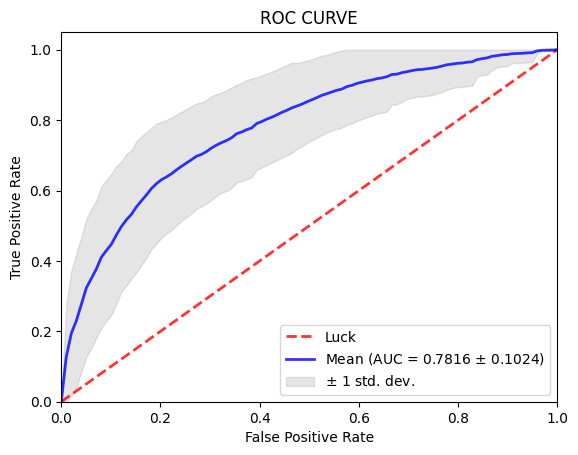

In [110]:
tpr = {}
roc_auc = {}
shuffle = False
precision = {}
recall = {}
average_precision = {}
balanced = True
fpr = {}
for legalUser in users:
    dataset = singapurAnalyser.createTrainingDataWithLabel(legalUser)    
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    X_train, X_validation, y_train, y_validation = singapurAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = SVMModel(dataset, users, kernel = 'rbf', C= 10)
    fpr[legalUser], tpr[legalUser], thr, precision[legalUser], recall[legalUser], average_precision[legalUser] = model.evaluate(X_train, y_train, X_validation, y_validation, user = legalUser, num_actions=1)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
    print(f"{legalUser}: {roc_auc[legalUser]:.3f} threshold: {threshold:.3f}")


plotROCs(fpr, tpr, roc_auc, users)



roc_path = f'wykresy\\SVM{limit}singapur_balanced{balanced}ROC'
pr_path = f'wykresy\\SVM{limit}singapur_balanced{balanced}PR'
plotROCs(fpr, tpr, roc_auc, users,False, True, roc_path)
plot_precisions_recalls(precision, recall, average_precision, True, pr_path)

## OC SVM

User 1 is being analyzed:
Test Accuracy: 0.50
1: 0.7871634781855956 threshold: -0.4810560046323257
User 2 is being analyzed:
Test Accuracy: 0.51
2: 0.7284186822877299 threshold: -0.5430911232514551
User 3 is being analyzed:
Test Accuracy: 0.54
3: 0.749433432283188 threshold: -0.6193152232830359
User 4 is being analyzed:
Test Accuracy: 0.50
4: 0.7481988234516491 threshold: -0.561384634145762
User 5 is being analyzed:
Test Accuracy: 0.50
5: 0.8065843621399177 threshold: -0.5188719776055791
User 6 is being analyzed:
Test Accuracy: 0.50
6: 0.8128573106742893 threshold: -0.5567889632605683
User 7 is being analyzed:
Test Accuracy: 0.50
7: 0.7637170521785906 threshold: -0.5628466485592718
User 8 is being analyzed:
Test Accuracy: 0.51
8: 0.74609375 threshold: -0.6168524902308489
User 9 is being analyzed:
Test Accuracy: 0.50
9: 0.7223557692307692 threshold: -0.6272525810635792
User 10 is being analyzed:
Test Accuracy: 0.50
10: 0.8459826886400313 threshold: -0.5526953329901156
User 11 is being a

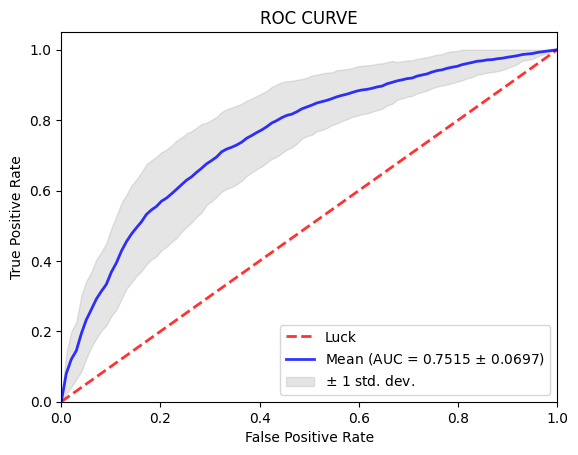

In [111]:
fpr = {}
tpr = {}
roc_auc = {}
shuffle = False
precision = {}
recall = {}
average_precision = {}
balanced = True
for legalUser in users:
    dataset = singapurAnalyser.createTrainingDataWithLabel(legalUser)    
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    
    x_negative = X[y == 0]
    x_positive = X[y == 1] 

    X_train, X_validation, y_train, y_validation = singapurAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    y_validation = np.where(y_validation == 0, -1, y_validation)

    model = OneClassSVMModel(dataset, users, nu = 0.5, kernel="rbf", gamma = 1)
    fpr[legalUser], tpr[legalUser], thr, precision[legalUser],  recall[legalUser],  average_precision[legalUser] = model.evaluate(x_positive, y_train, X_validation, y_validation, legalUser, num_actions=1)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja 
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
  
    print(str(legalUser) + ": " + str(roc_auc[legalUser])+" threshold: "+str(threshold))

plotROCs(fpr, tpr, roc_auc, users)


roc_path = f'wykresy\\OCSVM{limit}singapur_balanced{balanced}ROC'
pr_path = f'wykresy\\OCSVM{limit}singapur_balanced{balanced}PR'
plotROCs(fpr, tpr, roc_auc, users,False, True, roc_path)
plot_precisions_recalls(precision, recall, average_precision, True, pr_path)


## IF

User 1 is being analyzed:
Test Accuracy: 0.50
1: 0.5971368594182825 threshold: -0.025063759472442073
User 2 is being analyzed:
Test Accuracy: 0.50
2: 0.5665627362055934 threshold: -0.04285371875703192
User 3 is being analyzed:
Test Accuracy: 0.50
3: 0.6588145169012736 threshold: -0.01992013634311536
User 4 is being analyzed:
Test Accuracy: 0.50
4: 0.6023530967016986 threshold: -0.022787460264990917
User 5 is being analyzed:
Test Accuracy: 0.50
5: 0.4945130315500686 threshold: -0.04359036735638555
User 6 is being analyzed:
Test Accuracy: 0.50
6: 0.6351711175503172 threshold: -0.03283041402888502
User 7 is being analyzed:
Test Accuracy: 0.54
7: 0.6214545943566923 threshold: -0.006959592554222967
User 8 is being analyzed:
Test Accuracy: 0.50
8: 0.44537353515625 threshold: -0.03230874252156946
User 9 is being analyzed:
Test Accuracy: 0.51
9: 0.5757211538461539 threshold: -0.014944494761227386
User 10 is being analyzed:
Test Accuracy: 0.50
10: 0.6240891975157711 threshold: -0.02190118291922

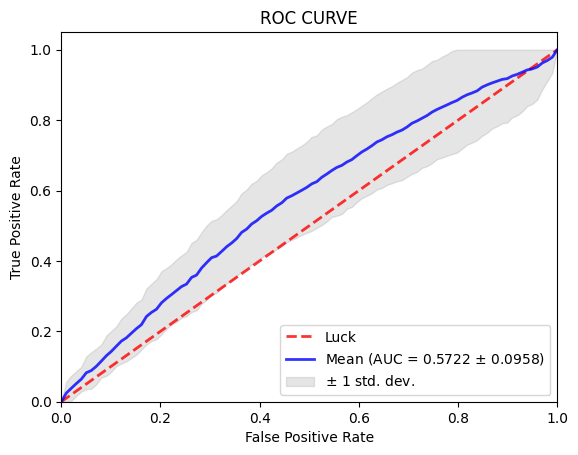

In [112]:
fpr = {}
tpr = {}
roc_auc = {}
shuffle = False
precision = {}
recall = {}
average_precision = {}
balanced = True
for legalUser in users:
    dataset = singapurAnalyser.createTrainingDataWithLabel(legalUser)    
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    
    x_negative = X[y == 0]
    x_positive = X[y == 1] 

    X_train, X_validation, y_train, y_validation = singapurAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    y_validation = np.where(y_validation == 0, -1, y_validation)

    model = IsolationForestModel(dataset, users, contamination= 0.5, n_estimators=200)
    fpr[legalUser], tpr[legalUser], thr, precision[legalUser],  recall[legalUser],  average_precision[legalUser] = model.evaluate(x_positive, y_train, X_validation, y_validation, legalUser)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja 
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
  
    print(str(legalUser) + ": " + str(roc_auc[legalUser])+" threshold: "+str(threshold))

plotROCs(fpr, tpr, roc_auc, users)


roc_path = f'wykresy\\IF{limit}singapur_balanced{balanced}ROC'
pr_path = f'wykresy\\IF{limit}singapur_balanced{balanced}PR'
plotROCs(fpr, tpr, roc_auc, users,False, True, roc_path)
plot_precisions_recalls(precision, recall, average_precision, True, pr_path)


The function below extract the stolen sessions and save it to the test_files path

In [113]:
#singapur_reader.processTestData()

# DFL

In [2]:
from utils.consts import *
from utils. plotting import *
from data_reader_dfl import *
from nonlegality_analyser import *
import random

In [3]:
users = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16, 17, 18, 19, 20, 21]
limit = 100000000
dfl_reader = DataReaderDfl(DFL, users, False, limit = limit)
dfl_reader.processDataWithoutLabels()


Error: line contains NUL

In [116]:

path = dfl_reader.getFileName()
dflAnalyser = nonLegalityAnalyser(path)
print(dflAnalyser.countActions())

type_of_action     1    3    4
userid                        
1                984  795   78
2               1004  929   37
3                196  426   22
4                702  678  140
5                611  692  226
6                882  658  256
7                569  555   63
8                341  839   51
9                666  831   70
10               299  720  203
11               812  493  260
12               826  682  109
13              1204  784   71
14               635  831   51
15               366  935   29
16               424  636  313
17               383  760   39
18               449  811   88
19               680  629  285
20               825  731   77
21               443  885   83


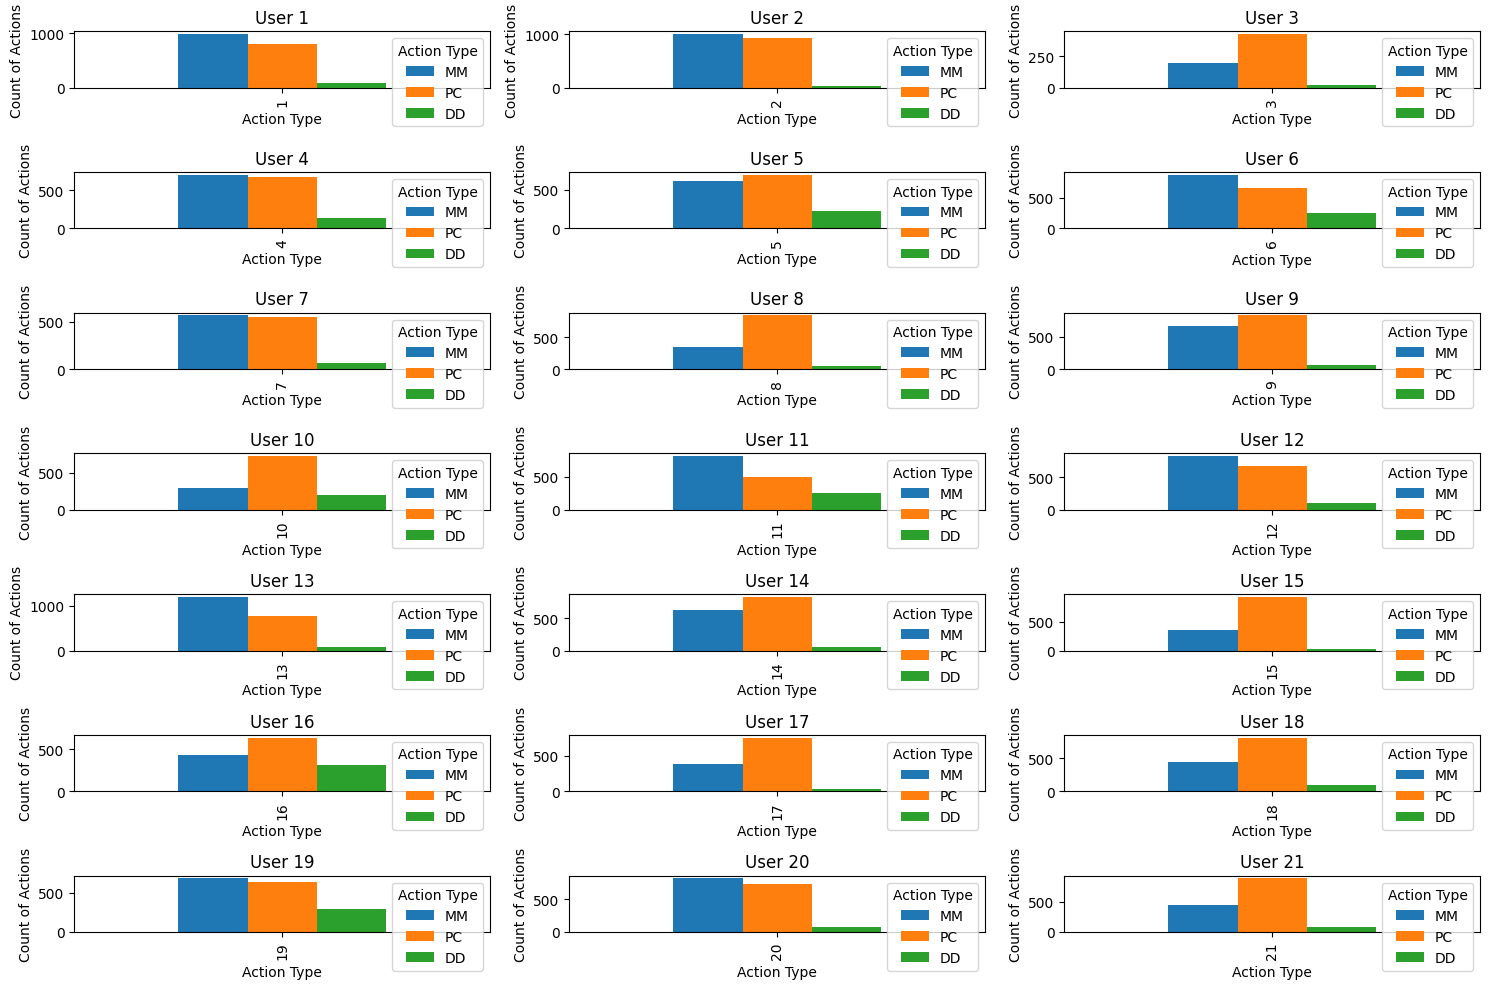

In [117]:
dflAnalyser.plotActionHistograms()

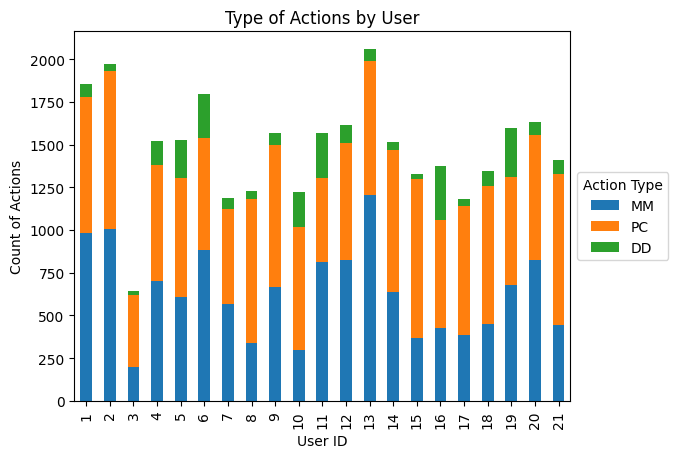

In [118]:
dflAnalyser.plotTypeOfActions(True)

## Random Forest

In [119]:
from RandomForestModel import *

User 1 is being analyzed:
CV Accuracy: 0.75 (+/- 0.07)
Test Accuracy: 0.77
1: 0.880 threshold: 0.521
User 2 is being analyzed:
CV Accuracy: 0.81 (+/- 0.07)
Test Accuracy: 0.79
2: 0.884 threshold: 0.509
User 3 is being analyzed:
CV Accuracy: 0.74 (+/- 0.28)
Test Accuracy: 0.71
3: 0.795 threshold: 0.500
User 4 is being analyzed:
CV Accuracy: 0.93 (+/- 0.04)
Test Accuracy: 0.94
4: 0.988 threshold: 0.465
User 5 is being analyzed:
CV Accuracy: 0.69 (+/- 0.10)
Test Accuracy: 0.70
5: 0.764 threshold: 0.514
User 6 is being analyzed:
CV Accuracy: 0.75 (+/- 0.26)
Test Accuracy: 0.64
6: 0.767 threshold: 0.425
User 7 is being analyzed:
CV Accuracy: 0.87 (+/- 0.17)
Test Accuracy: 0.77
7: 0.886 threshold: 0.384
User 8 is being analyzed:
CV Accuracy: 0.86 (+/- 0.10)
Test Accuracy: 0.63
8: 0.763 threshold: 0.361
User 9 is being analyzed:
CV Accuracy: 0.83 (+/- 0.07)
Test Accuracy: 0.85
9: 0.925 threshold: 0.538
User 10 is being analyzed:
CV Accuracy: 0.90 (+/- 0.05)
Test Accuracy: 0.90
10: 0.957 thres

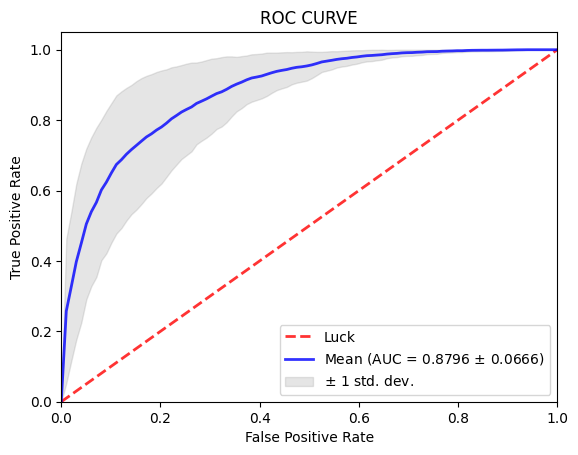

In [120]:
tpr = {}
roc_auc = {}
shuffle = False
precision = {}
recall = {}
average_precision = {}
balanced = True
fpr = {}

for legalUser in users:
    dataset = dflAnalyser.createTrainingDataWithLabel(legalUser)
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    X_train, X_validation, y_train, y_validation = dflAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = RandomForestModel(dataset, users)
    fpr[legalUser], tpr[legalUser], thr, precision[legalUser], recall[legalUser], average_precision[legalUser] = model.evaluate(X_train, y_train, X_validation, y_validation, scale = False, user = legalUser, num_actions=1)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
    print(f"{legalUser}: {roc_auc[legalUser]:.3f} threshold: {threshold:.3f}")

plotROCs(fpr, tpr, roc_auc, users)


roc_path = f'wykresy\\RF{limit}dfl_balanced{balanced}ROC'
pr_path = f'wykresy\\RF{limit}dfl_balanced{balanced}PR'
plotROCs(fpr, tpr, roc_auc, users,False, True, roc_path)
plot_precisions_recalls(precision, recall, average_precision, True, pr_path)

## SVM

In [121]:
from SVMmodel import *

User 1 is being analyzed:
CV Accuracy: 0.68 (+/- 0.04)
Test Accuracy: 0.67
1: 0.741 threshold: 0.546
User 2 is being analyzed:
CV Accuracy: 0.73 (+/- 0.07)
Test Accuracy: 0.70
2: 0.780 threshold: 0.557
User 3 is being analyzed:
CV Accuracy: 0.70 (+/- 0.23)
Test Accuracy: 0.66
3: 0.733 threshold: 0.477
User 4 is being analyzed:
CV Accuracy: 0.87 (+/- 0.05)
Test Accuracy: 0.81
4: 0.879 threshold: 0.443
User 5 is being analyzed:
CV Accuracy: 0.59 (+/- 0.06)
Test Accuracy: 0.57
5: 0.600 threshold: 0.513
User 6 is being analyzed:
CV Accuracy: 0.70 (+/- 0.25)
Test Accuracy: 0.54
6: 0.666 threshold: 0.290
User 7 is being analyzed:
CV Accuracy: 0.76 (+/- 0.31)
Test Accuracy: 0.68
7: 0.735 threshold: 0.668
User 8 is being analyzed:
CV Accuracy: 0.72 (+/- 0.06)
Test Accuracy: 0.58
8: 0.656 threshold: 0.391
User 9 is being analyzed:
CV Accuracy: 0.74 (+/- 0.06)
Test Accuracy: 0.77
9: 0.822 threshold: 0.543
User 10 is being analyzed:
CV Accuracy: 0.75 (+/- 0.07)
Test Accuracy: 0.79
10: 0.854 thres

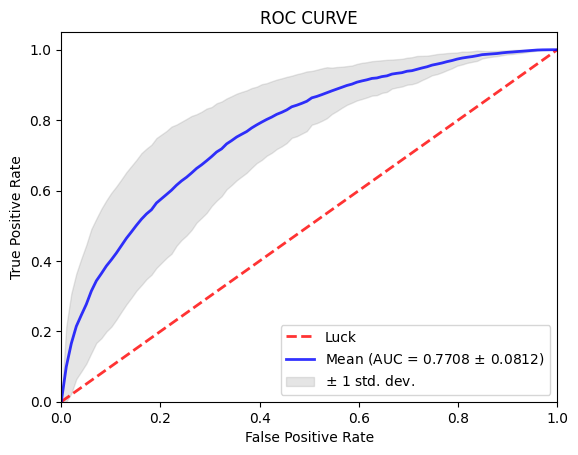

In [122]:
tpr = {}
roc_auc = {}
shuffle = False
precision = {}
recall = {}
average_precision = {}
balanced = True
fpr = {}
for legalUser in users:
    dataset = dflAnalyser.createTrainingDataWithLabel(legalUser)    
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    X_train, X_validation, y_train, y_validation = dflAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = SVMModel(dataset, users, kernel = 'rbf', C= 10)
    fpr[legalUser], tpr[legalUser], thr, precision[legalUser], recall[legalUser], average_precision[legalUser] = model.evaluate(X_train, y_train, X_validation, y_validation, user = legalUser, num_actions=1)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
    print(f"{legalUser}: {roc_auc[legalUser]:.3f} threshold: {threshold:.3f}")


plotROCs(fpr, tpr, roc_auc, users)



roc_path = f'wykresy\\SVM{limit}dfl_balanced{balanced}ROC'
pr_path = f'wykresy\\SVM{limit}dfl_balanced{balanced}PR'
plotROCs(fpr, tpr, roc_auc, users,False, True, roc_path)
plot_precisions_recalls(precision, recall, average_precision, True, pr_path)

## OC SVM

User 1 is being analyzed:
Test Accuracy: 0.50
1: 0.9249206268481049 threshold: -0.5152876372347206
User 2 is being analyzed:
Test Accuracy: 0.50
2: 0.7931149990981473 threshold: -0.5400432442821403
User 3 is being analyzed:
Test Accuracy: 0.50
3: 0.677825927734375 threshold: -0.5511219294379334
User 4 is being analyzed:
Test Accuracy: 0.50
4: 0.749339941135734 threshold: -0.5412865348539033
User 5 is being analyzed:
Test Accuracy: 0.50
5: 0.7920128997581295 threshold: -0.5144842274315536
User 6 is being analyzed:
Test Accuracy: 0.50
6: 0.8471458166836073 threshold: -0.5186598919931288
User 7 is being analyzed:
Test Accuracy: 0.50
7: 0.6596521212768609 threshold: -0.5348552960363621
User 8 is being analyzed:
Test Accuracy: 0.50
8: 0.44844338687289315 threshold: -0.6104972926286912
User 9 is being analyzed:
Test Accuracy: 0.50
9: 0.7828700915595749 threshold: -0.5446319094810916
User 10 is being analyzed:
Test Accuracy: 0.50
10: 0.862469766191884 threshold: -0.5125843063761841
User 11 is

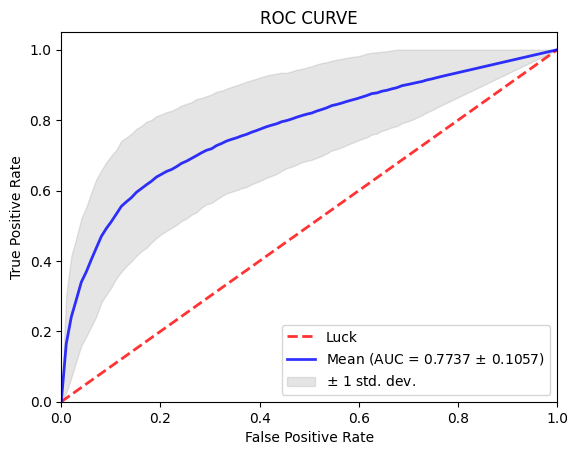

In [123]:
fpr = {}
tpr = {}
roc_auc = {}
shuffle = False
precision = {}
recall = {}
average_precision = {}
balanced = True
for legalUser in users:
    dataset = dflAnalyser.createTrainingDataWithLabel(legalUser)    
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    
    x_negative = X[y == 0]
    x_positive = X[y == 1] 

    X_train, X_validation, y_train, y_validation = dflAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    y_validation = np.where(y_validation == 0, -1, y_validation)

    model = OneClassSVMModel(dataset, users, nu = 0.5, kernel="rbf", gamma = 5)
    fpr[legalUser], tpr[legalUser], thr, precision[legalUser],  recall[legalUser],  average_precision[legalUser] = model.evaluate(x_positive, y_train, X_validation, y_validation, legalUser, num_actions=1)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja 
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
  
    print(str(legalUser) + ": " + str(roc_auc[legalUser])+" threshold: "+str(threshold))

plotROCs(fpr, tpr, roc_auc, users)


roc_path = f'wykresy\\OCSVM{limit}dfl_balanced{balanced}ROC'
pr_path = f'wykresy\\OCSVM{limit}dfl_balanced{balanced}PR'
plotROCs(fpr, tpr, roc_auc, users,False, True, roc_path)
plot_precisions_recalls(precision, recall, average_precision, True, pr_path)


User 1 is being analyzed:
Test Accuracy: 0.50
1: 0.5969805508533068 threshold: -0.025281393408115204
User 2 is being analyzed:
Test Accuracy: 0.50
2: 0.6381702697827824 threshold: -0.02099546031087758
User 3 is being analyzed:
Test Accuracy: 0.50
3: 0.396728515625 threshold: -0.027070137700908943
User 4 is being analyzed:
Test Accuracy: 0.50
4: 0.5772377077562327 threshold: -0.03575398127000909
User 5 is being analyzed:
Test Accuracy: 0.50
5: 0.5373394248857833 threshold: -0.07889537177825927
User 6 is being analyzed:
Test Accuracy: 0.50
6: 0.6395900093885056 threshold: -0.028944607796926754
User 7 is being analyzed:
Test Accuracy: 0.50
7: 0.6457832612295039 threshold: -0.058905469874189494
User 8 is being analyzed:
Test Accuracy: 0.50
8: 0.2826855707581466 threshold: -0.06565260917579047
User 9 is being analyzed:
Test Accuracy: 0.50
9: 0.6973328297726831 threshold: -0.03383003972075612
User 10 is being analyzed:
Test Accuracy: 0.50
10: 0.7872883633431874 threshold: -0.0458082619508095

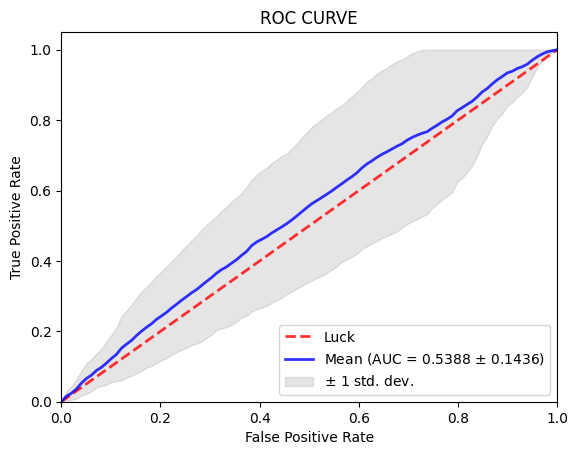

In [124]:
fpr = {}
tpr = {}
roc_auc = {}
shuffle = False
precision = {}
recall = {}
average_precision = {}
balanced = True
for legalUser in users:
    dataset = dflAnalyser.createTrainingDataWithLabel(legalUser)    
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    
    x_negative = X[y == 0]
    x_positive = X[y == 1] 

    X_train, X_validation, y_train, y_validation = dflAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    y_validation = np.where(y_validation == 0, -1, y_validation)

    model = IsolationForestModel(dataset, users, contamination= 0.5, n_estimators=200)
    fpr[legalUser], tpr[legalUser], thr, precision[legalUser],  recall[legalUser],  average_precision[legalUser] = model.evaluate(x_positive, y_train, X_validation, y_validation, legalUser, num_actions=1)
    threshold = -1
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr[legalUser], tpr[legalUser])(x), 0., 1.) ## brentq znajdowanie 0 , interpid interpolacja 
        threshold = interp1d(fpr[legalUser], thr)(eer)

    except (ZeroDivisionError, ValueError):
        print("Division by zero")

    roc_auc[legalUser] = auc(fpr[legalUser], tpr[legalUser])
  
    print(str(legalUser) + ": " + str(roc_auc[legalUser])+" threshold: "+str(threshold))

plotROCs(fpr, tpr, roc_auc, users)


roc_path = f'wykresy\\IF{limit}dfl_balanced{balanced}ROC'
pr_path = f'wykresy\\IF{limit}dfl_balanced{balanced}PR'
plotROCs(fpr, tpr, roc_auc, users,False, True, roc_path)
plot_precisions_recalls(precision, recall, average_precision, True, pr_path)


## SVM fearture improtance TWOS

In [14]:
# users = [1,2, 3, 4, 5, 6,9, 7, 16,20,21,23]
limit = 1000
users = [i for i in range (1,25)]
singapur_reader = DataReaderSingapur(SINGAPUR, users, limit = limit)
singapur_reader.processDataWithoutLabels()
path = singapur_reader.getFileName()
singapurAnalyser = nonLegalityAnalyser(path)
print(singapurAnalyser.countActions())

File already exist
type_of_action    1    3    4
userid                       
1               588  649  286
2               291  854  119
3               240  571   78
4               136  431   51
5                77  171   25
6               346  634  150
7               459  750  223
8                94  518   30
9               196  216  110
10              230  409   78
11              124  459   13
12              204  594  127
13              166  408   75
14              489  843  103
15              201  269   71
16              393  436  266
17              397  569  163
18              205  467  117
19              291  541  117
20              378  753  216
21              372  854  104
22              190  379  102
23              165  368   90
24              134  179   20


In [15]:
final = 0
i = 0
shuffle = True
for legalUser in users:
    dataset = singapurAnalyser.createTrainingDataWithLabel(legalUser)
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    X_train, X_validation, y_train, y_validation = singapurAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = RandomForestModel(dataset, users)
    feature_importance = model.calculateFeatureImportance(X_train, y_train, X_validation)
    final+=feature_importance
    i+=1

final = final/i
df1 = singapurAnalyser.returnDataframe()

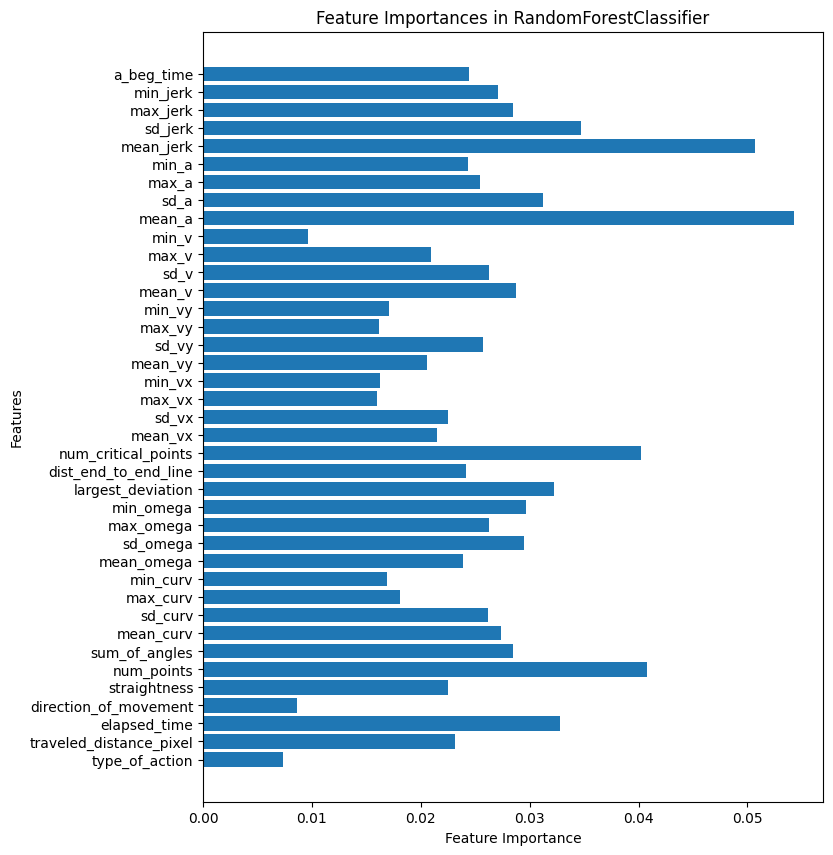

In [16]:
# permutationImportance = model.calculatePermutationImportance(X_train, y_train, X_validation, y_validation)
model.plotFeatureImportance(final, X, df1)

In [17]:
final = 0
i = 0
for legalUser in users:
    dataset = singapurAnalyser.createTrainingDataWithLabel(legalUser)
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    X_train, X_validation, y_train, y_validation = singapurAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = RandomForestModel(dataset, users)
    permutationImportance = model.calculatePermutationImportance(X_train, y_train, X_validation, y_validation)
    final+=permutationImportance
    i+=1

final = final/i
df1 = singapurAnalyser.returnDataframe()

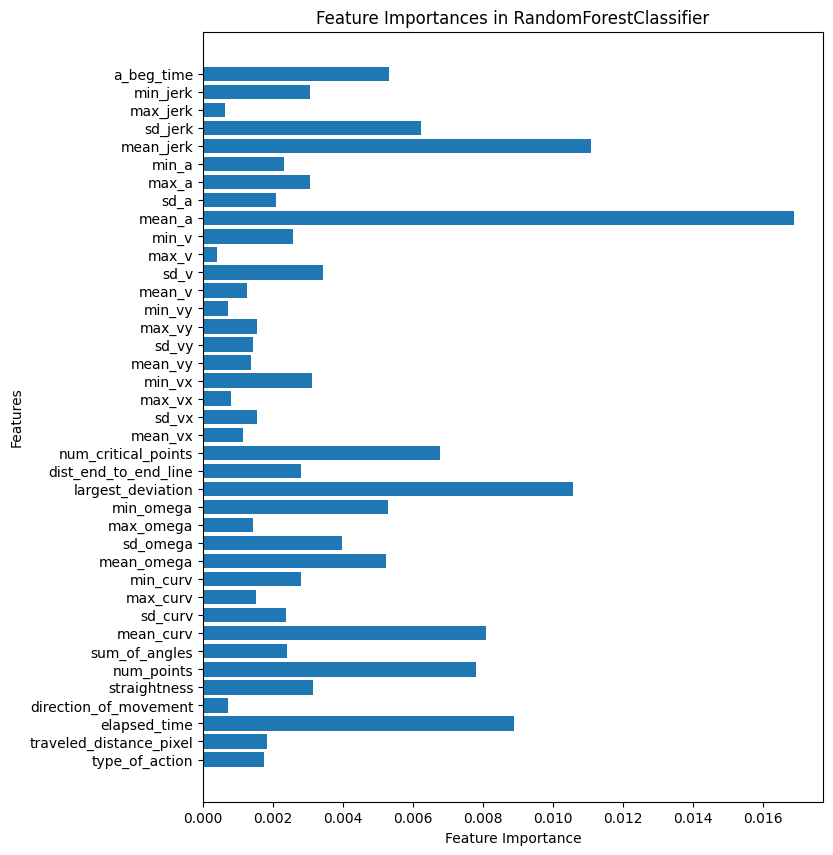

In [18]:
# permutationImportance = model.calculatePermutationImportance(X_train, y_train, X_validation, y_validation)
model.plotFeatureImportance(final, X, df1)

In [19]:
final = 0
i = 0
for legalUser in users:
    dataset = singapurAnalyser.createTrainingDataWithLabel(legalUser)
    X = dataset[:, 0:-1]
    y = dataset[:, -1]
    X_train, X_validation, y_train, y_validation = singapurAnalyser.trainingTestSplit(X, y, TEST_SIZE, shuffle)
    model = SVMModel(dataset, users)
    permutationImportance = model.calculatePermutationImportance(X_train, y_train, X_validation, y_validation)
    final+=permutationImportance
    i+=1

final = final/i
df1 = singapurAnalyser.returnDataframe()

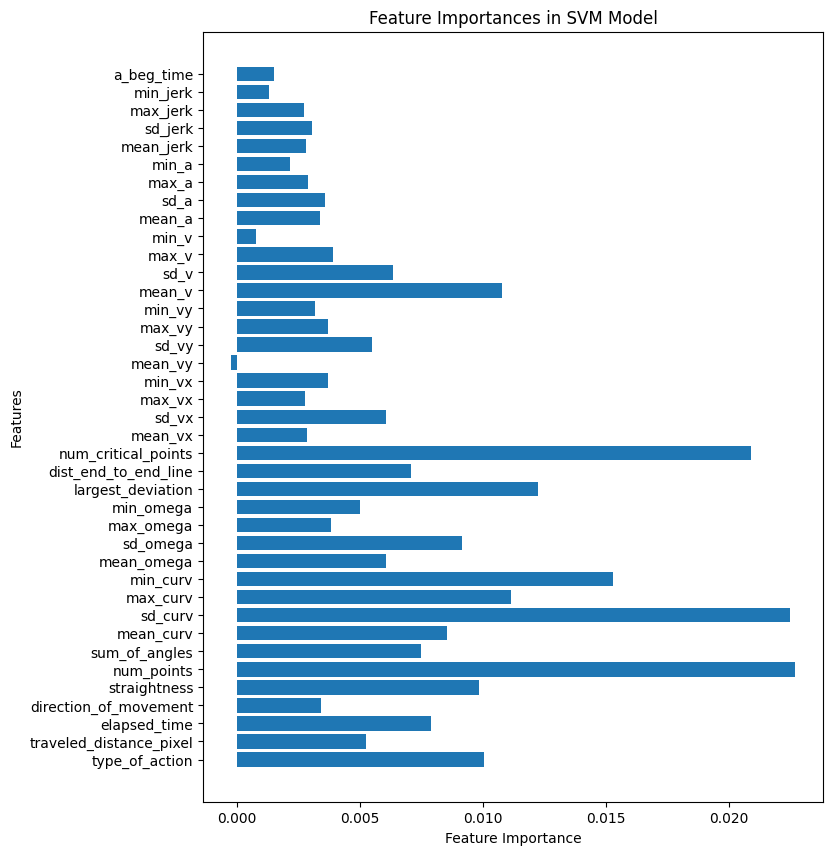

In [20]:
# permutationImportance = model.calculatePermutationImportance(X_train, y_train, X_validation, y_validation)
model.plotFeatureImportance(final, X, df1)